In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER




In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 336)

In [6]:
t_all.shape

(52, 7, 336)

In [7]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [8]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

Using TensorFlow backend.
/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [46]:
train_agg = t_all[:30, 0, :].reshape(30*14, 24)
train_appliance = {}
test_appliance = {}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    train_appliance[appliance] = t_all[:30, appliance_num+1, :].reshape(30*14, 24)
    test_appliance[appliance] = t_all[30:, appliance_num+1, :].reshape(22*14, 24)






test_hvac = t_all[30:, 1, :].reshape(22*14, 24)
test_fridge = t_all[30:, 2, :].reshape(22*14, 24)

test_mw = t_all[30:, 3, :].reshape(22*14, 24)



test_agg = t_all[30:, 0, :].reshape(22*14, 24)

oven
********************


/Users/nipun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  # Remove the CWD from sys.path while we load stuff.
/Users/nipun/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


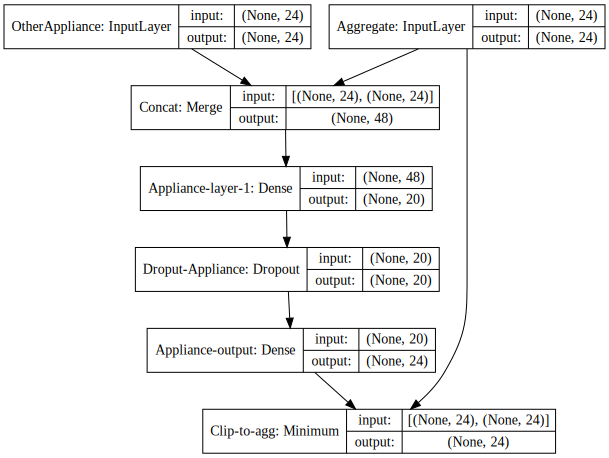

In [80]:
print(appliance)
print("*"*20)
np.random.seed(0)
from keras.layers.merge import Subtract, Minimum, Concatenate
from keras import regularizers
agg_input = keras.layers.Input(shape=[24],name='Aggregate')

appliance_input = keras.layers.Input(shape=[24],name='OtherAppliance')

concat = keras.layers.merge([agg_input, appliance_input], mode='concat',name='Concat')
appliance_dense_1 = keras.layers.Dense(units=20,name='Appliance-layer-1',activation='relu')(concat)
#appliance_batch = keras.layers.BatchNormalization()(appliance_dense_1)


dropout = keras.layers.Dropout(rate=0.3,name='Droput-Appliance')(appliance_dense_1)




out = keras.layers.Dense(units=24,name='Appliance-output',activation='relu')(dropout)
out = Minimum(name='Clip-to-agg')([out, agg_input])


model = keras.Model([agg_input,appliance_input], out)
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [76]:
pred_appliance ={}
for sup_appliance in APPLIANCES_ORDER[1:]:
    for test_appliance_name in APPLIANCES_ORDER[1:]:
        if sup_appliance!=test_appliance_name:
            print(sup_appliance, test_appliance_name)
            model.compile('adam','mean_absolute_error')
            model.fit([train_agg, train_appliance[sup_appliance]], train_appliance[test_appliance_name], epochs=300, validation_split=0.1)
            pred_appliance[(sup_appliance, test_appliance_name)] = model.predict([test_agg, test_appliance[sup_appliance]])

hvac fridge
Train on 378 samples, validate on 42 samples
Epoch 1/300
378/378 [==============================] - 2s 4ms/step - loss: 205.1245 - val_loss: 150.7324
Epoch 2/300
378/378 [==============================] - 0s 59us/step - loss: 138.9586 - val_loss: 124.0574
Epoch 3/300
378/378 [==============================] - 0s 58us/step - loss: 115.4814 - val_loss: 110.7931
Epoch 4/300
378/378 [==============================] - 0s 58us/step - loss: 100.1590 - val_loss: 104.0491
Epoch 5/300
378/378 [==============================] - 0s 59us/step - loss: 90.7163 - val_loss: 99.0927
Epoch 6/300
378/378 [==============================] - 0s 62us/step - loss: 85.3656 - val_loss: 96.4105
Epoch 7/300
378/378 [==============================] - 0s 60us/step - loss: 83.2403 - val_loss: 95.1660
Epoch 8/300
378/378 [==============================] - 0s 62us/step - loss: 82.1400 - val_loss: 95.0346
Epoch 9/300
378/378 [==============================] - 0s 58us/step - loss: 81.4671 - val_loss: 94.9945


Epoch 78/300
378/378 [==============================] - 0s 72us/step - loss: 39.2219 - val_loss: 43.7275
Epoch 79/300
378/378 [==============================] - 0s 63us/step - loss: 38.5748 - val_loss: 45.6668
Epoch 80/300
378/378 [==============================] - 0s 69us/step - loss: 37.6065 - val_loss: 46.1802
Epoch 81/300
378/378 [==============================] - 0s 68us/step - loss: 39.9059 - val_loss: 45.1521
Epoch 82/300
378/378 [==============================] - 0s 60us/step - loss: 39.4404 - val_loss: 41.0128
Epoch 83/300
378/378 [==============================] - 0s 63us/step - loss: 38.3555 - val_loss: 44.5764
Epoch 84/300
378/378 [==============================] - 0s 66us/step - loss: 37.3976 - val_loss: 41.2310
Epoch 85/300
378/378 [==============================] - 0s 66us/step - loss: 38.7269 - val_loss: 43.4175
Epoch 86/300
378/378 [==============================] - 0s 74us/step - loss: 37.0919 - val_loss: 41.4270
Epoch 87/300
378/378 [==============================] -

378/378 [==============================] - 0s 80us/step - loss: 33.1221 - val_loss: 38.6400
Epoch 156/300
378/378 [==============================] - 0s 78us/step - loss: 33.8878 - val_loss: 36.6033
Epoch 157/300
378/378 [==============================] - 0s 77us/step - loss: 33.0058 - val_loss: 37.1039
Epoch 158/300
378/378 [==============================] - 0s 73us/step - loss: 33.8049 - val_loss: 35.4381
Epoch 159/300
378/378 [==============================] - 0s 75us/step - loss: 33.4228 - val_loss: 37.0247
Epoch 160/300
378/378 [==============================] - 0s 66us/step - loss: 33.9400 - val_loss: 36.9076
Epoch 161/300
378/378 [==============================] - 0s 67us/step - loss: 33.4725 - val_loss: 34.7024
Epoch 162/300
378/378 [==============================] - 0s 74us/step - loss: 32.4608 - val_loss: 35.7385
Epoch 163/300
378/378 [==============================] - 0s 60us/step - loss: 32.4950 - val_loss: 35.1903
Epoch 164/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 65us/step - loss: 31.5897 - val_loss: 34.4214
Epoch 233/300
378/378 [==============================] - 0s 75us/step - loss: 30.8578 - val_loss: 34.9235
Epoch 234/300
378/378 [==============================] - 0s 72us/step - loss: 32.4636 - val_loss: 38.1432
Epoch 235/300
378/378 [==============================] - 0s 73us/step - loss: 30.6374 - val_loss: 36.7190
Epoch 236/300
378/378 [==============================] - 0s 70us/step - loss: 31.9168 - val_loss: 33.5875
Epoch 237/300
378/378 [==============================] - 0s 73us/step - loss: 32.9801 - val_loss: 32.9412
Epoch 238/300
378/378 [==============================] - 0s 66us/step - loss: 33.8998 - val_loss: 36.1205
Epoch 239/300
378/378 [==============================] - 0s 59us/step - loss: 33.1257 - val_loss: 34.5310
Epoch 240/300
378/378 [==============================] - 0s 63us/step - loss: 30.5069 - val_loss: 34.1425
Epoch 241/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 58us/step - loss: 6.6212 - val_loss: 8.9684
Epoch 10/300
378/378 [==============================] - 0s 67us/step - loss: 6.5760 - val_loss: 8.9437
Epoch 11/300
378/378 [==============================] - 0s 58us/step - loss: 6.5190 - val_loss: 8.9387
Epoch 12/300
378/378 [==============================] - 0s 66us/step - loss: 6.5152 - val_loss: 8.9474
Epoch 13/300
378/378 [==============================] - 0s 59us/step - loss: 6.3435 - val_loss: 8.9463
Epoch 14/300
378/378 [==============================] - 0s 62us/step - loss: 6.2898 - val_loss: 8.9513
Epoch 15/300
378/378 [==============================] - 0s 59us/step - loss: 6.1695 - val_loss: 8.9401
Epoch 16/300
378/378 [==============================] - 0s 70us/step - loss: 6.0359 - val_loss: 8.9166
Epoch 17/300
378/378 [==============================] - 0s 73us/step - loss: 5.8710 - val_loss: 8.8907
Epoch 18/300
378/378 [==============================] - 0s 64us/step - loss: 5.9044 - 

378/378 [==============================] - 0s 66us/step - loss: 5.2204 - val_loss: 8.9082
Epoch 89/300
378/378 [==============================] - 0s 68us/step - loss: 5.1829 - val_loss: 8.9417
Epoch 90/300
378/378 [==============================] - 0s 75us/step - loss: 5.1694 - val_loss: 8.9388
Epoch 91/300
378/378 [==============================] - 0s 75us/step - loss: 5.1733 - val_loss: 8.8940
Epoch 92/300
378/378 [==============================] - 0s 72us/step - loss: 5.2088 - val_loss: 8.8891
Epoch 93/300
378/378 [==============================] - 0s 67us/step - loss: 5.2226 - val_loss: 8.9256
Epoch 94/300
378/378 [==============================] - 0s 71us/step - loss: 5.1836 - val_loss: 8.9333
Epoch 95/300
378/378 [==============================] - ETA: 0s - loss: 5.765 - 0s 70us/step - loss: 5.2050 - val_loss: 8.9224
Epoch 96/300
378/378 [==============================] - 0s 58us/step - loss: 5.1808 - val_loss: 8.8994
Epoch 97/300
378/378 [==============================] - 0s 65u

Epoch 167/300
378/378 [==============================] - 0s 68us/step - loss: 5.1382 - val_loss: 9.0011
Epoch 168/300
378/378 [==============================] - 0s 76us/step - loss: 5.1494 - val_loss: 8.9742
Epoch 169/300
378/378 [==============================] - 0s 72us/step - loss: 5.1185 - val_loss: 8.9529
Epoch 170/300
378/378 [==============================] - 0s 60us/step - loss: 5.1181 - val_loss: 8.9848
Epoch 171/300
378/378 [==============================] - 0s 66us/step - loss: 5.1216 - val_loss: 8.9962
Epoch 172/300
378/378 [==============================] - 0s 59us/step - loss: 5.1151 - val_loss: 9.0094
Epoch 173/300
378/378 [==============================] - 0s 67us/step - loss: 5.1383 - val_loss: 8.9700
Epoch 174/300
378/378 [==============================] - 0s 62us/step - loss: 5.1065 - val_loss: 8.9855
Epoch 175/300
378/378 [==============================] - 0s 59us/step - loss: 5.1053 - val_loss: 8.9678
Epoch 176/300
378/378 [==============================] - 0s 54us

378/378 [==============================] - 0s 68us/step - loss: 5.0970 - val_loss: 9.2280
Epoch 246/300
378/378 [==============================] - 0s 79us/step - loss: 5.0969 - val_loss: 9.2779
Epoch 247/300
378/378 [==============================] - 0s 79us/step - loss: 5.1116 - val_loss: 9.3187
Epoch 248/300
378/378 [==============================] - 0s 66us/step - loss: 5.1250 - val_loss: 9.2253
Epoch 249/300
378/378 [==============================] - 0s 61us/step - loss: 5.0851 - val_loss: 9.1048
Epoch 250/300
378/378 [==============================] - 0s 59us/step - loss: 5.0963 - val_loss: 9.0511
Epoch 251/300
378/378 [==============================] - 0s 57us/step - loss: 5.0939 - val_loss: 9.0561
Epoch 252/300
378/378 [==============================] - 0s 51us/step - loss: 5.0939 - val_loss: 9.1670
Epoch 253/300
378/378 [==============================] - 0s 55us/step - loss: 5.0972 - val_loss: 9.1679
Epoch 254/300
378/378 [==============================] - 0s 55us/step - loss: 

Epoch 23/300
378/378 [==============================] - 0s 61us/step - loss: 13.4696 - val_loss: 16.0957
Epoch 24/300
378/378 [==============================] - 0s 56us/step - loss: 13.4600 - val_loss: 16.0466
Epoch 25/300
378/378 [==============================] - 0s 69us/step - loss: 13.4692 - val_loss: 15.9606
Epoch 26/300
378/378 [==============================] - 0s 67us/step - loss: 13.4488 - val_loss: 15.9073
Epoch 27/300
378/378 [==============================] - 0s 70us/step - loss: 13.4839 - val_loss: 15.8908
Epoch 28/300
378/378 [==============================] - 0s 74us/step - loss: 13.4572 - val_loss: 15.8860
Epoch 29/300
378/378 [==============================] - 0s 76us/step - loss: 13.4689 - val_loss: 15.8846
Epoch 30/300
378/378 [==============================] - 0s 75us/step - loss: 13.4588 - val_loss: 15.8842
Epoch 31/300
378/378 [==============================] - 0s 69us/step - loss: 13.4617 - val_loss: 15.8840
Epoch 32/300
378/378 [==============================] -

378/378 [==============================] - 0s 76us/step - loss: 13.4585 - val_loss: 15.8045
Epoch 102/300
378/378 [==============================] - 0s 70us/step - loss: 13.4911 - val_loss: 15.8045
Epoch 103/300
378/378 [==============================] - 0s 59us/step - loss: 13.4602 - val_loss: 15.8045
Epoch 104/300
378/378 [==============================] - 0s 75us/step - loss: 13.4904 - val_loss: 15.8045
Epoch 105/300
378/378 [==============================] - 0s 68us/step - loss: 13.4777 - val_loss: 15.8044
Epoch 106/300
378/378 [==============================] - 0s 58us/step - loss: 13.4926 - val_loss: 15.8044
Epoch 107/300
378/378 [==============================] - 0s 69us/step - loss: 13.4926 - val_loss: 15.8043
Epoch 108/300
378/378 [==============================] - 0s 58us/step - loss: 13.5087 - val_loss: 15.8043
Epoch 109/300
378/378 [==============================] - 0s 66us/step - loss: 13.4668 - val_loss: 15.8043
Epoch 110/300
378/378 [==============================] - 0s 

Epoch 178/300
378/378 [==============================] - 0s 62us/step - loss: 13.4505 - val_loss: 15.3560
Epoch 179/300
378/378 [==============================] - 0s 78us/step - loss: 13.4581 - val_loss: 15.3560
Epoch 180/300
378/378 [==============================] - 0s 72us/step - loss: 13.4426 - val_loss: 15.3560
Epoch 181/300
378/378 [==============================] - 0s 64us/step - loss: 13.4526 - val_loss: 15.3560
Epoch 182/300
378/378 [==============================] - 0s 69us/step - loss: 13.4452 - val_loss: 15.3560
Epoch 183/300
378/378 [==============================] - 0s 66us/step - loss: 13.4526 - val_loss: 15.3560
Epoch 184/300
378/378 [==============================] - 0s 63us/step - loss: 13.4496 - val_loss: 15.3560
Epoch 185/300
378/378 [==============================] - 0s 62us/step - loss: 13.4526 - val_loss: 15.3560
Epoch 186/300
378/378 [==============================] - 0s 56us/step - loss: 13.4515 - val_loss: 15.3560
Epoch 187/300
378/378 [=======================

378/378 [==============================] - 0s 67us/step - loss: 13.4506 - val_loss: 15.3557
Epoch 256/300
378/378 [==============================] - 0s 66us/step - loss: 13.4524 - val_loss: 15.3557
Epoch 257/300
378/378 [==============================] - 0s 64us/step - loss: 13.4452 - val_loss: 15.3557
Epoch 258/300
378/378 [==============================] - 0s 76us/step - loss: 13.4452 - val_loss: 15.3557
Epoch 259/300
378/378 [==============================] - 0s 75us/step - loss: 13.4546 - val_loss: 15.3557
Epoch 260/300
378/378 [==============================] - 0s 66us/step - loss: 13.4518 - val_loss: 15.3557
Epoch 261/300
378/378 [==============================] - 0s 72us/step - loss: 13.4452 - val_loss: 15.3557
Epoch 262/300
378/378 [==============================] - 0s 72us/step - loss: 13.4452 - val_loss: 15.3557
Epoch 263/300
378/378 [==============================] - 0s 68us/step - loss: 13.4452 - val_loss: 15.3557
Epoch 264/300
378/378 [==============================] - 0s 

Epoch 33/300
378/378 [==============================] - 0s 57us/step - loss: 4.7383 - val_loss: 4.6311
Epoch 34/300
378/378 [==============================] - 0s 60us/step - loss: 4.7315 - val_loss: 4.6311
Epoch 35/300
378/378 [==============================] - 0s 57us/step - loss: 4.7383 - val_loss: 4.6311
Epoch 36/300
378/378 [==============================] - 0s 52us/step - loss: 4.7439 - val_loss: 4.6311
Epoch 37/300
378/378 [==============================] - 0s 55us/step - loss: 4.7411 - val_loss: 4.6311
Epoch 38/300
378/378 [==============================] - 0s 54us/step - loss: 4.7360 - val_loss: 4.6311
Epoch 39/300
378/378 [==============================] - 0s 50us/step - loss: 4.7382 - val_loss: 4.6310
Epoch 40/300
378/378 [==============================] - 0s 56us/step - loss: 4.7313 - val_loss: 4.6310
Epoch 41/300
378/378 [==============================] - 0s 55us/step - loss: 4.7315 - val_loss: 4.6310
Epoch 42/300
378/378 [==============================] - 0s 55us/step - lo

Epoch 112/300
378/378 [==============================] - 0s 55us/step - loss: 4.7315 - val_loss: 4.6302
Epoch 113/300
378/378 [==============================] - 0s 63us/step - loss: 4.7477 - val_loss: 4.6302
Epoch 114/300
378/378 [==============================] - 0s 70us/step - loss: 4.7315 - val_loss: 4.6302
Epoch 115/300
378/378 [==============================] - 0s 76us/step - loss: 4.7367 - val_loss: 4.6302
Epoch 116/300
378/378 [==============================] - 0s 72us/step - loss: 4.7315 - val_loss: 4.6302
Epoch 117/300
378/378 [==============================] - 0s 74us/step - loss: 4.7315 - val_loss: 4.6301
Epoch 118/300
378/378 [==============================] - 0s 62us/step - loss: 4.7387 - val_loss: 4.6301
Epoch 119/300
378/378 [==============================] - 0s 74us/step - loss: 4.7315 - val_loss: 4.6301
Epoch 120/300
378/378 [==============================] - 0s 71us/step - loss: 4.7315 - val_loss: 4.6301
Epoch 121/300
378/378 [==============================] - 0s 64us

378/378 [==============================] - 0s 76us/step - loss: 4.7294 - val_loss: 4.6293
Epoch 191/300
378/378 [==============================] - 0s 79us/step - loss: 4.7315 - val_loss: 4.6293
Epoch 192/300
378/378 [==============================] - 0s 77us/step - loss: 4.7373 - val_loss: 4.6293
Epoch 193/300
378/378 [==============================] - 0s 58us/step - loss: 4.7411 - val_loss: 4.6293
Epoch 194/300
378/378 [==============================] - 0s 59us/step - loss: 4.7363 - val_loss: 4.6292
Epoch 195/300
378/378 [==============================] - 0s 56us/step - loss: 4.7395 - val_loss: 4.6292
Epoch 196/300
378/378 [==============================] - 0s 55us/step - loss: 4.7315 - val_loss: 4.6292
Epoch 197/300
378/378 [==============================] - 0s 56us/step - loss: 4.7367 - val_loss: 4.6292
Epoch 198/300
378/378 [==============================] - 0s 51us/step - loss: 4.7373 - val_loss: 4.6292
Epoch 199/300
378/378 [==============================] - 0s 65us/step - loss: 

378/378 [==============================] - 0s 70us/step - loss: 4.7315 - val_loss: 4.6281
Epoch 269/300
378/378 [==============================] - 0s 76us/step - loss: 4.7273 - val_loss: 4.6281
Epoch 270/300
378/378 [==============================] - 0s 58us/step - loss: 4.7367 - val_loss: 4.6281
Epoch 271/300
378/378 [==============================] - 0s 59us/step - loss: 4.7388 - val_loss: 4.6281
Epoch 272/300
378/378 [==============================] - 0s 67us/step - loss: 4.7281 - val_loss: 4.6281
Epoch 273/300
378/378 [==============================] - 0s 73us/step - loss: 4.7315 - val_loss: 4.6281
Epoch 274/300
378/378 [==============================] - 0s 75us/step - loss: 4.7427 - val_loss: 4.6281
Epoch 275/300
378/378 [==============================] - 0s 72us/step - loss: 4.7315 - val_loss: 4.6280
Epoch 276/300
378/378 [==============================] - 0s 64us/step - loss: 4.7357 - val_loss: 4.6280
Epoch 277/300
378/378 [==============================] - 0s 73us/step - loss: 

Epoch 46/300
378/378 [==============================] - 0s 70us/step - loss: 14.4587 - val_loss: 13.7776
Epoch 47/300
378/378 [==============================] - 0s 62us/step - loss: 14.4587 - val_loss: 13.7776
Epoch 48/300
378/378 [==============================] - 0s 64us/step - loss: 14.4538 - val_loss: 13.7776
Epoch 49/300
378/378 [==============================] - 0s 59us/step - loss: 14.4487 - val_loss: 13.7776
Epoch 50/300
378/378 [==============================] - 0s 58us/step - loss: 14.4632 - val_loss: 13.7776
Epoch 51/300
378/378 [==============================] - 0s 55us/step - loss: 14.4587 - val_loss: 13.7776
Epoch 52/300
378/378 [==============================] - 0s 55us/step - loss: 14.4587 - val_loss: 13.7776
Epoch 53/300
378/378 [==============================] - 0s 60us/step - loss: 14.4563 - val_loss: 13.7776
Epoch 54/300
378/378 [==============================] - 0s 57us/step - loss: 14.4587 - val_loss: 13.7776
Epoch 55/300
378/378 [==============================] -

Epoch 124/300
378/378 [==============================] - 0s 55us/step - loss: 14.4550 - val_loss: 13.7779
Epoch 125/300
378/378 [==============================] - 0s 55us/step - loss: 14.4484 - val_loss: 13.7779
Epoch 126/300
378/378 [==============================] - 0s 55us/step - loss: 14.4587 - val_loss: 13.7779
Epoch 127/300
378/378 [==============================] - 0s 56us/step - loss: 14.4535 - val_loss: 13.7779
Epoch 128/300
378/378 [==============================] - 0s 64us/step - loss: 14.4587 - val_loss: 13.7779
Epoch 129/300
378/378 [==============================] - 0s 56us/step - loss: 14.4594 - val_loss: 13.7779
Epoch 130/300
378/378 [==============================] - 0s 51us/step - loss: 14.4535 - val_loss: 13.7779
Epoch 131/300
378/378 [==============================] - 0s 61us/step - loss: 14.4564 - val_loss: 13.7779
Epoch 132/300
378/378 [==============================] - 0s 55us/step - loss: 14.4483 - val_loss: 13.7779
Epoch 133/300
378/378 [=======================

378/378 [==============================] - 0s 57us/step - loss: 14.4587 - val_loss: 13.7782
Epoch 202/300
378/378 [==============================] - 0s 52us/step - loss: 14.4587 - val_loss: 13.7782
Epoch 203/300
378/378 [==============================] - 0s 60us/step - loss: 14.4447 - val_loss: 13.7782
Epoch 204/300
378/378 [==============================] - 0s 56us/step - loss: 14.4480 - val_loss: 13.7782
Epoch 205/300
378/378 [==============================] - 0s 51us/step - loss: 14.4587 - val_loss: 13.7782
Epoch 206/300
378/378 [==============================] - 0s 56us/step - loss: 14.4587 - val_loss: 13.7782
Epoch 207/300
378/378 [==============================] - 0s 55us/step - loss: 14.4583 - val_loss: 13.7782
Epoch 208/300
378/378 [==============================] - 0s 60us/step - loss: 14.4543 - val_loss: 13.7782
Epoch 209/300
378/378 [==============================] - 0s 69us/step - loss: 14.4588 - val_loss: 13.7782
Epoch 210/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 58us/step - loss: 14.4543 - val_loss: 13.7783
Epoch 279/300
378/378 [==============================] - 0s 54us/step - loss: 14.4555 - val_loss: 13.7783
Epoch 280/300
378/378 [==============================] - 0s 58us/step - loss: 14.4633 - val_loss: 13.7783
Epoch 281/300
378/378 [==============================] - 0s 63us/step - loss: 14.4533 - val_loss: 13.7783
Epoch 282/300
378/378 [==============================] - 0s 59us/step - loss: 14.4533 - val_loss: 13.7783
Epoch 283/300
378/378 [==============================] - 0s 56us/step - loss: 14.4587 - val_loss: 13.7783
Epoch 284/300
378/378 [==============================] - 0s 58us/step - loss: 14.4487 - val_loss: 13.7784
Epoch 285/300
378/378 [==============================] - 0s 57us/step - loss: 14.4587 - val_loss: 13.7784
Epoch 286/300
378/378 [==============================] - 0s 51us/step - loss: 14.4604 - val_loss: 13.7784
Epoch 287/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 58us/step - loss: 129.7917 - val_loss: 139.3657
Epoch 55/300
378/378 [==============================] - 0s 51us/step - loss: 128.2519 - val_loss: 139.3657
Epoch 56/300
378/378 [==============================] - 0s 54us/step - loss: 128.0978 - val_loss: 139.3657
Epoch 57/300
378/378 [==============================] - 0s 59us/step - loss: 128.4980 - val_loss: 139.3657
Epoch 58/300
378/378 [==============================] - 0s 52us/step - loss: 128.7594 - val_loss: 139.3657
Epoch 59/300
378/378 [==============================] - 0s 62us/step - loss: 131.2867 - val_loss: 139.3657
Epoch 60/300
378/378 [==============================] - 0s 56us/step - loss: 130.6450 - val_loss: 139.3657
Epoch 61/300
378/378 [==============================] - 0s 54us/step - loss: 128.5253 - val_loss: 139.3657
Epoch 62/300
378/378 [==============================] - 0s 57us/step - loss: 128.8989 - val_loss: 139.3657
Epoch 63/300
378/378 [============================

378/378 [==============================] - 0s 56us/step - loss: 127.4490 - val_loss: 139.3657
Epoch 131/300
378/378 [==============================] - 0s 59us/step - loss: 127.5203 - val_loss: 139.3657
Epoch 132/300
378/378 [==============================] - 0s 54us/step - loss: 127.8706 - val_loss: 139.3657
Epoch 133/300
378/378 [==============================] - 0s 51us/step - loss: 127.5236 - val_loss: 139.3657
Epoch 134/300
378/378 [==============================] - 0s 55us/step - loss: 127.6623 - val_loss: 139.3657
Epoch 135/300
378/378 [==============================] - 0s 55us/step - loss: 127.8484 - val_loss: 139.3657
Epoch 136/300
378/378 [==============================] - 0s 55us/step - loss: 130.3260 - val_loss: 139.3657
Epoch 137/300
378/378 [==============================] - 0s 56us/step - loss: 127.9882 - val_loss: 139.3657
Epoch 138/300
378/378 [==============================] - 0s 56us/step - loss: 127.5840 - val_loss: 139.3657
Epoch 139/300
378/378 [===================

Epoch 206/300
378/378 [==============================] - ETA: 0s - loss: 122.304 - 0s 51us/step - loss: 128.5846 - val_loss: 139.3657
Epoch 207/300
378/378 [==============================] - 0s 53us/step - loss: 127.4432 - val_loss: 139.3657
Epoch 208/300
378/378 [==============================] - 0s 58us/step - loss: 127.4639 - val_loss: 139.3657
Epoch 209/300
378/378 [==============================] - 0s 54us/step - loss: 127.4731 - val_loss: 139.3657
Epoch 210/300
378/378 [==============================] - 0s 59us/step - loss: 127.3608 - val_loss: 139.3657
Epoch 211/300
378/378 [==============================] - 0s 60us/step - loss: 127.4302 - val_loss: 139.3657
Epoch 212/300
378/378 [==============================] - 0s 55us/step - loss: 127.2907 - val_loss: 139.3657
Epoch 213/300
378/378 [==============================] - 0s 59us/step - loss: 127.4467 - val_loss: 139.3657
Epoch 214/300
378/378 [==============================] - 0s 55us/step - loss: 127.5872 - val_loss: 139.3657
Ep

378/378 [==============================] - 0s 56us/step - loss: 127.4473 - val_loss: 139.3657
Epoch 282/300
378/378 [==============================] - 0s 58us/step - loss: 127.4825 - val_loss: 139.3657
Epoch 283/300
378/378 [==============================] - 0s 54us/step - loss: 127.4148 - val_loss: 139.3657
Epoch 284/300
378/378 [==============================] - 0s 55us/step - loss: 127.4621 - val_loss: 139.3657
Epoch 285/300
378/378 [==============================] - 0s 57us/step - loss: 127.4716 - val_loss: 139.3657
Epoch 286/300
378/378 [==============================] - 0s 55us/step - loss: 127.5312 - val_loss: 139.3657
Epoch 287/300
378/378 [==============================] - 0s 56us/step - loss: 127.5845 - val_loss: 139.3657
Epoch 288/300
378/378 [==============================] - 0s 55us/step - loss: 127.2976 - val_loss: 139.3657
Epoch 289/300
378/378 [==============================] - 0s 50us/step - loss: 127.4965 - val_loss: 139.3657
Epoch 290/300
378/378 [===================

378/378 [==============================] - 0s 59us/step - loss: 6.4177 - val_loss: 8.3305
Epoch 58/300
378/378 [==============================] - 0s 51us/step - loss: 6.3196 - val_loss: 8.3305
Epoch 59/300
378/378 [==============================] - 0s 53us/step - loss: 6.3272 - val_loss: 8.3305
Epoch 60/300
378/378 [==============================] - 0s 58us/step - loss: 6.3434 - val_loss: 8.3305
Epoch 61/300
378/378 [==============================] - 0s 55us/step - loss: 6.2149 - val_loss: 8.3305
Epoch 62/300
378/378 [==============================] - 0s 61us/step - loss: 6.2738 - val_loss: 8.3305
Epoch 63/300
378/378 [==============================] - 0s 57us/step - loss: 6.5511 - val_loss: 8.3305
Epoch 64/300
378/378 [==============================] - 0s 53us/step - loss: 6.3262 - val_loss: 8.3305
Epoch 65/300
378/378 [==============================] - 0s 57us/step - loss: 6.2855 - val_loss: 8.3305
Epoch 66/300
378/378 [==============================] - 0s 56us/step - loss: 6.3319 - 

378/378 [==============================] - 0s 53us/step - loss: 6.1914 - val_loss: 8.3305
Epoch 137/300
378/378 [==============================] - 0s 60us/step - loss: 6.2497 - val_loss: 8.3305
Epoch 138/300
378/378 [==============================] - 0s 58us/step - loss: 6.2287 - val_loss: 8.3305
Epoch 139/300
378/378 [==============================] - 0s 54us/step - loss: 6.2309 - val_loss: 8.3305
Epoch 140/300
378/378 [==============================] - 0s 58us/step - loss: 6.3295 - val_loss: 8.3305
Epoch 141/300
378/378 [==============================] - 0s 54us/step - loss: 6.2321 - val_loss: 8.3305
Epoch 142/300
378/378 [==============================] - 0s 57us/step - loss: 6.3388 - val_loss: 8.3305
Epoch 143/300
378/378 [==============================] - 0s 57us/step - loss: 6.2715 - val_loss: 8.3305
Epoch 144/300
378/378 [==============================] - 0s 55us/step - loss: 6.1746 - val_loss: 8.3305
Epoch 145/300
378/378 [==============================] - 0s 57us/step - loss: 

378/378 [==============================] - 0s 56us/step - loss: 6.2421 - val_loss: 8.3305
Epoch 215/300
378/378 [==============================] - 0s 59us/step - loss: 6.2537 - val_loss: 8.3305
Epoch 216/300
378/378 [==============================] - 0s 55us/step - loss: 6.2345 - val_loss: 8.3305
Epoch 217/300
378/378 [==============================] - 0s 58us/step - loss: 6.1774 - val_loss: 8.3305
Epoch 218/300
378/378 [==============================] - 0s 56us/step - loss: 6.2076 - val_loss: 8.3305
Epoch 219/300
378/378 [==============================] - 0s 53us/step - loss: 6.2368 - val_loss: 8.3305
Epoch 220/300
378/378 [==============================] - 0s 57us/step - loss: 6.2030 - val_loss: 8.3305
Epoch 221/300
378/378 [==============================] - 0s 57us/step - loss: 6.2200 - val_loss: 8.3305
Epoch 222/300
378/378 [==============================] - 0s 51us/step - loss: 6.2269 - val_loss: 8.3305
Epoch 223/300
378/378 [==============================] - 0s 55us/step - loss: 

378/378 [==============================] - 0s 57us/step - loss: 6.2340 - val_loss: 8.3305
Epoch 293/300
378/378 [==============================] - 0s 55us/step - loss: 6.1909 - val_loss: 8.3305
Epoch 294/300
378/378 [==============================] - 0s 53us/step - loss: 6.1638 - val_loss: 8.3305
Epoch 295/300
378/378 [==============================] - 0s 58us/step - loss: 6.1570 - val_loss: 8.3305
Epoch 296/300
378/378 [==============================] - 0s 54us/step - loss: 6.2512 - val_loss: 8.3305
Epoch 297/300
378/378 [==============================] - 0s 56us/step - loss: 6.2413 - val_loss: 8.3305
Epoch 298/300
378/378 [==============================] - 0s 57us/step - loss: 6.1446 - val_loss: 8.3305
Epoch 299/300
378/378 [==============================] - 0s 54us/step - loss: 6.1795 - val_loss: 8.3305
Epoch 300/300
378/378 [==============================] - 0s 59us/step - loss: 6.2532 - val_loss: 8.3305
fridge dw
Train on 378 samples, validate on 42 samples
Epoch 1/300
378/378 [==

378/378 [==============================] - 0s 60us/step - loss: 13.6322 - val_loss: 15.0648
Epoch 70/300
378/378 [==============================] - 0s 58us/step - loss: 13.6038 - val_loss: 15.0648
Epoch 71/300
378/378 [==============================] - 0s 55us/step - loss: 13.6241 - val_loss: 15.0648
Epoch 72/300
378/378 [==============================] - 0s 58us/step - loss: 13.6630 - val_loss: 15.0648
Epoch 73/300
378/378 [==============================] - 0s 56us/step - loss: 13.6291 - val_loss: 15.0648
Epoch 74/300
378/378 [==============================] - 0s 59us/step - loss: 13.6571 - val_loss: 15.0648
Epoch 75/300
378/378 [==============================] - 0s 57us/step - loss: 13.5843 - val_loss: 15.0648
Epoch 76/300
378/378 [==============================] - 0s 52us/step - loss: 13.5814 - val_loss: 15.0648
Epoch 77/300
378/378 [==============================] - 0s 59us/step - loss: 13.5929 - val_loss: 15.0648
Epoch 78/300
378/378 [==============================] - 0s 56us/step

378/378 [==============================] - 0s 58us/step - loss: 13.5437 - val_loss: 15.0648
Epoch 147/300
378/378 [==============================] - 0s 63us/step - loss: 13.5447 - val_loss: 15.0648
Epoch 148/300
378/378 [==============================] - 0s 56us/step - loss: 13.4939 - val_loss: 15.0648
Epoch 149/300
378/378 [==============================] - 0s 53us/step - loss: 13.5603 - val_loss: 15.0648
Epoch 150/300
378/378 [==============================] - 0s 60us/step - loss: 13.5330 - val_loss: 15.0648
Epoch 151/300
378/378 [==============================] - 0s 55us/step - loss: 13.5575 - val_loss: 15.0648
Epoch 152/300
378/378 [==============================] - 0s 54us/step - loss: 13.5359 - val_loss: 15.0648
Epoch 153/300
378/378 [==============================] - 0s 58us/step - loss: 13.5513 - val_loss: 15.0648
Epoch 154/300
378/378 [==============================] - 0s 55us/step - loss: 13.5333 - val_loss: 15.0648
Epoch 155/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 59us/step - loss: 13.4945 - val_loss: 15.0648
Epoch 224/300
378/378 [==============================] - 0s 56us/step - loss: 13.5169 - val_loss: 15.0648
Epoch 225/300
378/378 [==============================] - 0s 54us/step - loss: 13.4815 - val_loss: 15.0648
Epoch 226/300
378/378 [==============================] - 0s 58us/step - loss: 13.4894 - val_loss: 15.0648
Epoch 227/300
378/378 [==============================] - 0s 55us/step - loss: 13.4920 - val_loss: 15.0648
Epoch 228/300
378/378 [==============================] - 0s 53us/step - loss: 13.5020 - val_loss: 15.0648
Epoch 229/300
378/378 [==============================] - 0s 57us/step - loss: 13.4942 - val_loss: 15.0648
Epoch 230/300
378/378 [==============================] - 0s 55us/step - loss: 13.4890 - val_loss: 15.0648
Epoch 231/300
378/378 [==============================] - 0s 53us/step - loss: 13.4884 - val_loss: 15.0648
Epoch 232/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 56us/step - loss: 13.4497 - val_loss: 15.0648
fridge wm
Train on 378 samples, validate on 42 samples
Epoch 1/300
378/378 [==============================] - 2s 4ms/step - loss: 4.7385 - val_loss: 4.3410
Epoch 2/300
378/378 [==============================] - 0s 57us/step - loss: 4.7369 - val_loss: 4.3410
Epoch 3/300
378/378 [==============================] - 0s 63us/step - loss: 4.7349 - val_loss: 4.3410
Epoch 4/300
378/378 [==============================] - 0s 51us/step - loss: 4.7368 - val_loss: 4.3410
Epoch 5/300
378/378 [==============================] - 0s 58us/step - loss: 4.7366 - val_loss: 4.3410
Epoch 6/300
378/378 [==============================] - 0s 55us/step - loss: 4.7362 - val_loss: 4.3410
Epoch 7/300
378/378 [==============================] - 0s 53us/step - loss: 4.7357 - val_loss: 4.3410
Epoch 8/300
378/378 [==============================] - 0s 58us/step - loss: 4.7354 - val_loss: 4.3410
Epoch 9/300
378/378 [=================

378/378 [==============================] - 0s 56us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 80/300
378/378 [==============================] - 0s 56us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 81/300
378/378 [==============================] - 0s 54us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 82/300
378/378 [==============================] - 0s 57us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 83/300
378/378 [==============================] - 0s 56us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 84/300
378/378 [==============================] - 0s 52us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 85/300
378/378 [==============================] - 0s 57us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 86/300
378/378 [==============================] - 0s 58us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 87/300
378/378 [==============================] - 0s 56us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 88/300
378/378 [==============================] - 0s 59us/step - loss: 4.7315 - 

378/378 [==============================] - 0s 51us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 159/300
378/378 [==============================] - 0s 57us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 160/300
378/378 [==============================] - 0s 58us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 161/300
378/378 [==============================] - 0s 54us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 162/300
378/378 [==============================] - 0s 57us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 163/300
378/378 [==============================] - 0s 57us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 164/300
378/378 [==============================] - 0s 51us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 165/300
378/378 [==============================] - 0s 61us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 166/300
378/378 [==============================] - 0s 56us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 167/300
378/378 [==============================] - 0s 54us/step - loss: 

378/378 [==============================] - 0s 56us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 237/300
378/378 [==============================] - 0s 59us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 238/300
378/378 [==============================] - 0s 55us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 239/300
378/378 [==============================] - 0s 56us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 240/300
378/378 [==============================] - 0s 57us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 241/300
378/378 [==============================] - 0s 55us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 242/300
378/378 [==============================] - 0s 60us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 243/300
378/378 [==============================] - 0s 57us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 244/300
378/378 [==============================] - 0s 51us/step - loss: 4.7315 - val_loss: 4.3410
Epoch 245/300
378/378 [==============================] - 0s 58us/step - loss: 

378/378 [==============================] - 0s 58us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 15/300
378/378 [==============================] - 0s 59us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 16/300
378/378 [==============================] - 0s 56us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 17/300
378/378 [==============================] - 0s 58us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 18/300
378/378 [==============================] - 0s 55us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 19/300
378/378 [==============================] - 0s 52us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 20/300
378/378 [==============================] - 0s 58us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 21/300
378/378 [==============================] - 0s 56us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 22/300
378/378 [==============================] - 0s 51us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 23/300
378/378 [==============================] - 0s 56us/step

Epoch 92/300
378/378 [==============================] - 0s 68us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 93/300
378/378 [==============================] - 0s 58us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 94/300
378/378 [==============================] - 0s 63us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 95/300
378/378 [==============================] - 0s 58us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 96/300
378/378 [==============================] - 0s 70us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 97/300
378/378 [==============================] - 0s 56us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 98/300
378/378 [==============================] - 0s 54us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 99/300
378/378 [==============================] - 0s 62us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 100/300
378/378 [==============================] - 0s 55us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 101/300
378/378 [==============================]

378/378 [==============================] - 0s 60us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 170/300
378/378 [==============================] - 0s 56us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 171/300
378/378 [==============================] - 0s 59us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 172/300
378/378 [==============================] - 0s 54us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 173/300
378/378 [==============================] - 0s 58us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 174/300
378/378 [==============================] - 0s 57us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 175/300
378/378 [==============================] - 0s 54us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 176/300
378/378 [==============================] - 0s 59us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 177/300
378/378 [==============================] - 0s 56us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 178/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 57us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 247/300
378/378 [==============================] - 0s 58us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 248/300
378/378 [==============================] - 0s 55us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 249/300
378/378 [==============================] - 0s 59us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 250/300
378/378 [==============================] - 0s 55us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 251/300
378/378 [==============================] - 0s 53us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 252/300
378/378 [==============================] - 0s 57us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 253/300
378/378 [==============================] - 0s 55us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 254/300
378/378 [==============================] - 0s 52us/step - loss: 14.4587 - val_loss: 13.5165
Epoch 255/300
378/378 [==============================] - 0s 

Epoch 23/300
378/378 [==============================] - 0s 56us/step - loss: 131.0964 - val_loss: 139.3657
Epoch 24/300
378/378 [==============================] - 0s 58us/step - loss: 129.2928 - val_loss: 139.3657
Epoch 25/300
378/378 [==============================] - 0s 54us/step - loss: 135.3942 - val_loss: 139.3657
Epoch 26/300
378/378 [==============================] - 0s 62us/step - loss: 131.5997 - val_loss: 139.3657
Epoch 27/300
378/378 [==============================] - 0s 55us/step - loss: 128.6124 - val_loss: 139.3657
Epoch 28/300
378/378 [==============================] - 0s 51us/step - loss: 127.9947 - val_loss: 139.3657
Epoch 29/300
378/378 [==============================] - 0s 57us/step - loss: 129.4012 - val_loss: 139.3657
Epoch 30/300
378/378 [==============================] - 0s 56us/step - loss: 128.2727 - val_loss: 139.3657
Epoch 31/300
378/378 [==============================] - 0s 51us/step - loss: 130.2130 - val_loss: 139.3657
Epoch 32/300
378/378 [===============

378/378 [==============================] - 0s 63us/step - loss: 127.3595 - val_loss: 139.3657
Epoch 100/300
378/378 [==============================] - 0s 54us/step - loss: 127.9808 - val_loss: 139.3657
Epoch 101/300
378/378 [==============================] - 0s 65us/step - loss: 127.5661 - val_loss: 139.3657
Epoch 102/300
378/378 [==============================] - 0s 59us/step - loss: 127.5685 - val_loss: 139.3657
Epoch 103/300
378/378 [==============================] - 0s 60us/step - loss: 128.4905 - val_loss: 139.3657
Epoch 104/300
378/378 [==============================] - 0s 58us/step - loss: 127.8537 - val_loss: 139.3657
Epoch 105/300
378/378 [==============================] - 0s 54us/step - loss: 127.7330 - val_loss: 139.3657
Epoch 106/300
378/378 [==============================] - 0s 60us/step - loss: 127.3695 - val_loss: 139.3657
Epoch 107/300
378/378 [==============================] - 0s 55us/step - loss: 128.0555 - val_loss: 139.3657
Epoch 108/300
378/378 [===================

378/378 [==============================] - 0s 57us/step - loss: 127.4637 - val_loss: 139.3657
Epoch 175/300
378/378 [==============================] - 0s 57us/step - loss: 129.8448 - val_loss: 139.3657
Epoch 176/300
378/378 [==============================] - 0s 51us/step - loss: 127.3785 - val_loss: 139.3657
Epoch 177/300
378/378 [==============================] - 0s 57us/step - loss: 127.3725 - val_loss: 139.3657
Epoch 178/300
378/378 [==============================] - 0s 56us/step - loss: 127.5214 - val_loss: 139.3657
Epoch 179/300
378/378 [==============================] - 0s 52us/step - loss: 128.0179 - val_loss: 139.3657
Epoch 180/300
378/378 [==============================] - 0s 61us/step - loss: 127.7565 - val_loss: 139.3657
Epoch 181/300
378/378 [==============================] - 0s 55us/step - loss: 128.7934 - val_loss: 139.3657
Epoch 182/300
378/378 [==============================] - 0s 55us/step - loss: 127.5383 - val_loss: 139.3657
Epoch 183/300
378/378 [===================

Epoch 250/300
378/378 [==============================] - 0s 58us/step - loss: 128.8834 - val_loss: 139.1428
Epoch 251/300
378/378 [==============================] - 0s 58us/step - loss: 127.7272 - val_loss: 139.1119
Epoch 252/300
378/378 [==============================] - 0s 51us/step - loss: 127.5029 - val_loss: 139.0904
Epoch 253/300
378/378 [==============================] - 0s 57us/step - loss: 131.2331 - val_loss: 139.0903
Epoch 254/300
378/378 [==============================] - 0s 56us/step - loss: 127.5221 - val_loss: 139.0783
Epoch 255/300
378/378 [==============================] - 0s 52us/step - loss: 127.5815 - val_loss: 139.1541
Epoch 256/300
378/378 [==============================] - 0s 58us/step - loss: 127.2644 - val_loss: 139.2012
Epoch 257/300
378/378 [==============================] - 0s 56us/step - loss: 127.3773 - val_loss: 139.2542
Epoch 258/300
378/378 [==============================] - 0s 52us/step - loss: 127.4205 - val_loss: 139.3657
Epoch 259/300
378/378 [=====

378/378 [==============================] - 0s 60us/step - loss: 133.8350 - val_loss: 95.8715
Epoch 26/300
378/378 [==============================] - 0s 59us/step - loss: 88.6024 - val_loss: 94.5328
Epoch 27/300
378/378 [==============================] - 0s 56us/step - loss: 79.7490 - val_loss: 95.4102
Epoch 28/300
378/378 [==============================] - 0s 60us/step - loss: 78.9344 - val_loss: 95.2704
Epoch 29/300
378/378 [==============================] - 0s 57us/step - loss: 77.3920 - val_loss: 95.2044
Epoch 30/300
378/378 [==============================] - 0s 59us/step - loss: 77.6847 - val_loss: 95.3411
Epoch 31/300
378/378 [==============================] - 0s 56us/step - loss: 77.7800 - val_loss: 95.1055
Epoch 32/300
378/378 [==============================] - 0s 51us/step - loss: 77.8557 - val_loss: 95.4133
Epoch 33/300
378/378 [==============================] - 0s 58us/step - loss: 78.4696 - val_loss: 95.0919
Epoch 34/300
378/378 [==============================] - 0s 57us/ste

378/378 [==============================] - 0s 54us/step - loss: 71.6105 - val_loss: 91.6383
Epoch 104/300
378/378 [==============================] - 0s 62us/step - loss: 71.7387 - val_loss: 92.4535
Epoch 105/300
378/378 [==============================] - 0s 56us/step - loss: 73.9159 - val_loss: 91.5790
Epoch 106/300
378/378 [==============================] - 0s 53us/step - loss: 73.2915 - val_loss: 91.8919
Epoch 107/300
378/378 [==============================] - 0s 59us/step - loss: 73.6737 - val_loss: 92.7364
Epoch 108/300
378/378 [==============================] - 0s 54us/step - loss: 72.9479 - val_loss: 92.7038
Epoch 109/300
378/378 [==============================] - 0s 56us/step - loss: 72.4011 - val_loss: 92.4770
Epoch 110/300
378/378 [==============================] - 0s 59us/step - loss: 73.3299 - val_loss: 91.8882
Epoch 111/300
378/378 [==============================] - 0s 51us/step - loss: 71.9485 - val_loss: 89.9436
Epoch 112/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 59us/step - loss: 69.3019 - val_loss: 87.7322
Epoch 181/300
378/378 [==============================] - 0s 54us/step - loss: 70.5027 - val_loss: 87.3635
Epoch 182/300
378/378 [==============================] - 0s 55us/step - loss: 69.7444 - val_loss: 87.9248
Epoch 183/300
378/378 [==============================] - 0s 60us/step - loss: 70.6707 - val_loss: 87.3920
Epoch 184/300
378/378 [==============================] - 0s 55us/step - loss: 67.9682 - val_loss: 87.5634
Epoch 185/300
378/378 [==============================] - 0s 59us/step - loss: 68.0498 - val_loss: 87.5725
Epoch 186/300
378/378 [==============================] - 0s 56us/step - loss: 68.5160 - val_loss: 87.5535
Epoch 187/300
378/378 [==============================] - 0s 52us/step - loss: 70.0152 - val_loss: 87.7841
Epoch 188/300
378/378 [==============================] - 0s 58us/step - loss: 67.8743 - val_loss: 88.0590
Epoch 189/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 57us/step - loss: 65.6508 - val_loss: 88.3310
Epoch 258/300
378/378 [==============================] - 0s 60us/step - loss: 68.4470 - val_loss: 88.0045
Epoch 259/300
378/378 [==============================] - 0s 54us/step - loss: 66.6262 - val_loss: 88.1841
Epoch 260/300
378/378 [==============================] - 0s 59us/step - loss: 67.8431 - val_loss: 88.0720
Epoch 261/300
378/378 [==============================] - 0s 55us/step - loss: 67.2532 - val_loss: 88.2099
Epoch 262/300
378/378 [==============================] - 0s 50us/step - loss: 67.9342 - val_loss: 87.7816
Epoch 263/300
378/378 [==============================] - 0s 56us/step - loss: 68.7509 - val_loss: 87.6550
Epoch 264/300
378/378 [==============================] - 0s 59us/step - loss: 65.6376 - val_loss: 87.8749
Epoch 265/300
378/378 [==============================] - 0s 54us/step - loss: 67.8276 - val_loss: 88.7764
Epoch 266/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 57us/step - loss: 13.5888 - val_loss: 15.2055
Epoch 35/300
378/378 [==============================] - 0s 54us/step - loss: 13.5937 - val_loss: 15.2052
Epoch 36/300
378/378 [==============================] - 0s 57us/step - loss: 13.6073 - val_loss: 15.2050
Epoch 37/300
378/378 [==============================] - 0s 57us/step - loss: 13.5838 - val_loss: 15.2046
Epoch 38/300
378/378 [==============================] - 0s 52us/step - loss: 13.5750 - val_loss: 15.2044
Epoch 39/300
378/378 [==============================] - 0s 56us/step - loss: 13.5624 - val_loss: 15.2041
Epoch 40/300
378/378 [==============================] - 0s 58us/step - loss: 13.5762 - val_loss: 15.2039
Epoch 41/300
378/378 [==============================] - 0s 56us/step - loss: 13.5898 - val_loss: 15.2037
Epoch 42/300
378/378 [==============================] - 0s 58us/step - loss: 13.5766 - val_loss: 15.2035
Epoch 43/300
378/378 [==============================] - 0s 56us/step

378/378 [==============================] - 0s 57us/step - loss: 13.4860 - val_loss: 15.1878
Epoch 113/300
378/378 [==============================] - 0s 55us/step - loss: 13.4682 - val_loss: 15.1877
Epoch 114/300
378/378 [==============================] - 0s 59us/step - loss: 13.4721 - val_loss: 15.1876
Epoch 115/300
378/378 [==============================] - 0s 56us/step - loss: 13.4911 - val_loss: 15.1877
Epoch 116/300
378/378 [==============================] - 0s 62us/step - loss: 13.4697 - val_loss: 15.1875
Epoch 117/300
378/378 [==============================] - 0s 57us/step - loss: 13.4847 - val_loss: 15.1873
Epoch 118/300
378/378 [==============================] - 0s 52us/step - loss: 13.4730 - val_loss: 15.1867
Epoch 119/300
378/378 [==============================] - 0s 60us/step - loss: 13.4878 - val_loss: 15.1863
Epoch 120/300
378/378 [==============================] - 0s 55us/step - loss: 13.4480 - val_loss: 15.1860
Epoch 121/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 60us/step - loss: 13.4608 - val_loss: 15.1713
Epoch 190/300
378/378 [==============================] - 0s 53us/step - loss: 13.4575 - val_loss: 15.1713
Epoch 191/300
378/378 [==============================] - 0s 57us/step - loss: 13.4669 - val_loss: 15.1712
Epoch 192/300
378/378 [==============================] - 0s 58us/step - loss: 13.4617 - val_loss: 15.1710
Epoch 193/300
378/378 [==============================] - 0s 52us/step - loss: 13.4494 - val_loss: 15.1708
Epoch 194/300
378/378 [==============================] - 0s 59us/step - loss: 13.4619 - val_loss: 15.1708
Epoch 195/300
378/378 [==============================] - 0s 57us/step - loss: 13.4556 - val_loss: 15.1707
Epoch 196/300
378/378 [==============================] - 0s 52us/step - loss: 13.4635 - val_loss: 15.1707
Epoch 197/300
378/378 [==============================] - 0s 57us/step - loss: 13.4533 - val_loss: 15.1707
Epoch 198/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 57us/step - loss: 13.4567 - val_loss: 15.1642
Epoch 267/300
378/378 [==============================] - 0s 58us/step - loss: 13.4538 - val_loss: 15.1639
Epoch 268/300
378/378 [==============================] - 0s 56us/step - loss: 13.4600 - val_loss: 15.1638
Epoch 269/300
378/378 [==============================] - 0s 51us/step - loss: 13.4496 - val_loss: 15.1638
Epoch 270/300
378/378 [==============================] - 0s 55us/step - loss: 13.4456 - val_loss: 15.1637
Epoch 271/300
378/378 [==============================] - 0s 58us/step - loss: 13.4574 - val_loss: 15.1637
Epoch 272/300
378/378 [==============================] - 0s 52us/step - loss: 13.4517 - val_loss: 15.1637
Epoch 273/300
378/378 [==============================] - 0s 57us/step - loss: 13.4431 - val_loss: 15.1635
Epoch 274/300
378/378 [==============================] - 0s 55us/step - loss: 13.4564 - val_loss: 15.1634
Epoch 275/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 57us/step - loss: 4.7363 - val_loss: 4.4015
Epoch 45/300
378/378 [==============================] - 0s 59us/step - loss: 4.7421 - val_loss: 4.4015
Epoch 46/300
378/378 [==============================] - 0s 52us/step - loss: 4.7445 - val_loss: 4.4015
Epoch 47/300
378/378 [==============================] - 0s 59us/step - loss: 4.7380 - val_loss: 4.4015
Epoch 48/300
378/378 [==============================] - 0s 57us/step - loss: 4.7425 - val_loss: 4.4015
Epoch 49/300
378/378 [==============================] - 0s 52us/step - loss: 4.7469 - val_loss: 4.4015
Epoch 50/300
378/378 [==============================] - 0s 58us/step - loss: 4.7380 - val_loss: 4.4014
Epoch 51/300
378/378 [==============================] - 0s 56us/step - loss: 4.7347 - val_loss: 4.4014
Epoch 52/300
378/378 [==============================] - 0s 52us/step - loss: 4.7437 - val_loss: 4.4014
Epoch 53/300
378/378 [==============================] - 0s 59us/step - loss: 4.7404 - 

378/378 [==============================] - 0s 57us/step - loss: 4.7428 - val_loss: 4.4012
Epoch 124/300
378/378 [==============================] - 0s 59us/step - loss: 4.7348 - val_loss: 4.4012
Epoch 125/300
378/378 [==============================] - 0s 57us/step - loss: 4.7367 - val_loss: 4.4012
Epoch 126/300
378/378 [==============================] - 0s 53us/step - loss: 4.7384 - val_loss: 4.4012
Epoch 127/300
378/378 [==============================] - 0s 59us/step - loss: 4.7399 - val_loss: 4.4012
Epoch 128/300
378/378 [==============================] - 0s 57us/step - loss: 4.7392 - val_loss: 4.4012
Epoch 129/300
378/378 [==============================] - 0s 50us/step - loss: 4.7383 - val_loss: 4.4012
Epoch 130/300
378/378 [==============================] - 0s 60us/step - loss: 4.7351 - val_loss: 4.4012
Epoch 131/300
378/378 [==============================] - 0s 56us/step - loss: 4.7367 - val_loss: 4.4011
Epoch 132/300
378/378 [==============================] - 0s 52us/step - loss: 

Epoch 202/300
378/378 [==============================] - 0s 60us/step - loss: 4.7339 - val_loss: 4.4009
Epoch 203/300
378/378 [==============================] - 0s 56us/step - loss: 4.7357 - val_loss: 4.4009
Epoch 204/300
378/378 [==============================] - 0s 52us/step - loss: 4.7336 - val_loss: 4.4009
Epoch 205/300
378/378 [==============================] - 0s 59us/step - loss: 4.7355 - val_loss: 4.4009
Epoch 206/300
378/378 [==============================] - 0s 55us/step - loss: 4.7353 - val_loss: 4.4008
Epoch 207/300
378/378 [==============================] - 0s 52us/step - loss: 4.7337 - val_loss: 4.4008
Epoch 208/300
378/378 [==============================] - 0s 57us/step - loss: 4.7341 - val_loss: 4.4008
Epoch 209/300
378/378 [==============================] - 0s 59us/step - loss: 4.7351 - val_loss: 4.4008
Epoch 210/300
378/378 [==============================] - 0s 59us/step - loss: 4.7329 - val_loss: 4.4008
Epoch 211/300
378/378 [==============================] - 0s 57us

Epoch 281/300
378/378 [==============================] - 0s 57us/step - loss: 4.7315 - val_loss: 4.4005
Epoch 282/300
378/378 [==============================] - 0s 62us/step - loss: 4.7326 - val_loss: 4.4005
Epoch 283/300
378/378 [==============================] - 0s 56us/step - loss: 4.7334 - val_loss: 4.4005
Epoch 284/300
378/378 [==============================] - 0s 59us/step - loss: 4.7327 - val_loss: 4.4005
Epoch 285/300
378/378 [==============================] - 0s 55us/step - loss: 4.7318 - val_loss: 4.4005
Epoch 286/300
378/378 [==============================] - 0s 52us/step - loss: 4.7325 - val_loss: 4.4005
Epoch 287/300
378/378 [==============================] - 0s 58us/step - loss: 4.7329 - val_loss: 4.4005
Epoch 288/300
378/378 [==============================] - 0s 56us/step - loss: 4.7338 - val_loss: 4.4005
Epoch 289/300
378/378 [==============================] - 0s 56us/step - loss: 4.7316 - val_loss: 4.4005
Epoch 290/300
378/378 [==============================] - 0s 58us

Epoch 59/300
378/378 [==============================] - 0s 55us/step - loss: 14.4571 - val_loss: 13.5762
Epoch 60/300
378/378 [==============================] - 0s 53us/step - loss: 14.4595 - val_loss: 13.5762
Epoch 61/300
378/378 [==============================] - 0s 60us/step - loss: 14.4563 - val_loss: 13.5762
Epoch 62/300
378/378 [==============================] - 0s 56us/step - loss: 14.4583 - val_loss: 13.5762
Epoch 63/300
378/378 [==============================] - 0s 52us/step - loss: 14.4571 - val_loss: 13.5762
Epoch 64/300
378/378 [==============================] - 0s 58us/step - loss: 14.4591 - val_loss: 13.5762
Epoch 65/300
378/378 [==============================] - 0s 55us/step - loss: 14.4575 - val_loss: 13.5762
Epoch 66/300
378/378 [==============================] - 0s 53us/step - loss: 14.4602 - val_loss: 13.5762
Epoch 67/300
378/378 [==============================] - 0s 59us/step - loss: 14.4576 - val_loss: 13.5762
Epoch 68/300
378/378 [==============================] -

378/378 [==============================] - 0s 56us/step - loss: 14.4551 - val_loss: 13.5763
Epoch 137/300
378/378 [==============================] - 0s 58us/step - loss: 14.4587 - val_loss: 13.5764
Epoch 138/300
378/378 [==============================] - 0s 54us/step - loss: 14.4578 - val_loss: 13.5764
Epoch 139/300
378/378 [==============================] - 0s 60us/step - loss: 14.4565 - val_loss: 13.5764
Epoch 140/300
378/378 [==============================] - 0s 57us/step - loss: 14.4587 - val_loss: 13.5764
Epoch 141/300
378/378 [==============================] - 0s 52us/step - loss: 14.4576 - val_loss: 13.5764
Epoch 142/300
378/378 [==============================] - 0s 58us/step - loss: 14.4576 - val_loss: 13.5764
Epoch 143/300
378/378 [==============================] - 0s 59us/step - loss: 14.4542 - val_loss: 13.5764
Epoch 144/300
378/378 [==============================] - 0s 59us/step - loss: 14.4564 - val_loss: 13.5764
Epoch 145/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 62us/step - loss: 14.4537 - val_loss: 13.5765
Epoch 214/300
378/378 [==============================] - 0s 56us/step - loss: 14.4593 - val_loss: 13.5765
Epoch 215/300
378/378 [==============================] - 0s 59us/step - loss: 14.4557 - val_loss: 13.5765
Epoch 216/300
378/378 [==============================] - 0s 56us/step - loss: 14.4526 - val_loss: 13.5765
Epoch 217/300
378/378 [==============================] - 0s 53us/step - loss: 14.4563 - val_loss: 13.5766
Epoch 218/300
378/378 [==============================] - 0s 59us/step - loss: 14.4602 - val_loss: 13.5766
Epoch 219/300
378/378 [==============================] - 0s 55us/step - loss: 14.4584 - val_loss: 13.5766
Epoch 220/300
378/378 [==============================] - 0s 58us/step - loss: 14.4549 - val_loss: 13.5766
Epoch 221/300
378/378 [==============================] - 0s 59us/step - loss: 14.4555 - val_loss: 13.5766
Epoch 222/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 54us/step - loss: 14.4566 - val_loss: 13.5767
Epoch 291/300
378/378 [==============================] - 0s 62us/step - loss: 14.4587 - val_loss: 13.5767
Epoch 292/300
378/378 [==============================] - 0s 55us/step - loss: 14.4534 - val_loss: 13.5767
Epoch 293/300
378/378 [==============================] - 0s 57us/step - loss: 14.4517 - val_loss: 13.5768
Epoch 294/300
378/378 [==============================] - 0s 58us/step - loss: 14.4584 - val_loss: 13.5768
Epoch 295/300
378/378 [==============================] - 0s 52us/step - loss: 14.4607 - val_loss: 13.5768
Epoch 296/300
378/378 [==============================] - 0s 59us/step - loss: 14.4534 - val_loss: 13.5768
Epoch 297/300
378/378 [==============================] - 0s 57us/step - loss: 14.4583 - val_loss: 13.5768
Epoch 298/300
378/378 [==============================] - 0s 53us/step - loss: 14.4553 - val_loss: 13.5768
Epoch 299/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 57us/step - loss: 861.9203 - val_loss: 874.7618
Epoch 67/300
378/378 [==============================] - 0s 61us/step - loss: 861.9251 - val_loss: 874.7617
Epoch 68/300
378/378 [==============================] - 0s 56us/step - loss: 861.9149 - val_loss: 874.7618
Epoch 69/300
378/378 [==============================] - 0s 60us/step - loss: 861.9205 - val_loss: 874.7618
Epoch 70/300
378/378 [==============================] - 0s 56us/step - loss: 861.9170 - val_loss: 874.7618
Epoch 71/300
378/378 [==============================] - 0s 53us/step - loss: 861.9153 - val_loss: 874.7618
Epoch 72/300
378/378 [==============================] - 0s 58us/step - loss: 861.9220 - val_loss: 874.7618
Epoch 73/300
378/378 [==============================] - 0s 57us/step - loss: 861.9193 - val_loss: 874.7618
Epoch 74/300
378/378 [==============================] - 0s 52us/step - loss: 861.9206 - val_loss: 874.7618
Epoch 75/300
378/378 [============================

378/378 [==============================] - 0s 60us/step - loss: 144.9650 - val_loss: 139.3657
Epoch 143/300
378/378 [==============================] - 0s 57us/step - loss: 139.0095 - val_loss: 139.3657
Epoch 144/300
378/378 [==============================] - 0s 56us/step - loss: 134.2741 - val_loss: 139.3657
Epoch 145/300
378/378 [==============================] - 0s 60us/step - loss: 129.6738 - val_loss: 139.3657
Epoch 146/300
378/378 [==============================] - 0s 56us/step - loss: 139.4922 - val_loss: 139.3657
Epoch 147/300
378/378 [==============================] - 0s 60us/step - loss: 132.3607 - val_loss: 139.3657
Epoch 148/300
378/378 [==============================] - 0s 56us/step - loss: 139.5179 - val_loss: 139.3657
Epoch 149/300
378/378 [==============================] - 0s 51us/step - loss: 134.3814 - val_loss: 139.3657
Epoch 150/300
378/378 [==============================] - 0s 58us/step - loss: 136.2983 - val_loss: 139.3657
Epoch 151/300
378/378 [===================

Epoch 218/300
378/378 [==============================] - 0s 53us/step - loss: 130.4752 - val_loss: 139.3657
Epoch 219/300
378/378 [==============================] - 0s 58us/step - loss: 130.4403 - val_loss: 139.3657
Epoch 220/300
378/378 [==============================] - 0s 57us/step - loss: 127.6741 - val_loss: 139.2831
Epoch 221/300
378/378 [==============================] - 0s 53us/step - loss: 134.0346 - val_loss: 139.3001
Epoch 222/300
378/378 [==============================] - 0s 61us/step - loss: 129.1111 - val_loss: 139.2721
Epoch 223/300
378/378 [==============================] - 0s 56us/step - loss: 131.0187 - val_loss: 139.2544
Epoch 224/300
378/378 [==============================] - 0s 57us/step - loss: 133.2675 - val_loss: 139.3825
Epoch 225/300
378/378 [==============================] - 0s 58us/step - loss: 129.9981 - val_loss: 139.3670
Epoch 226/300
378/378 [==============================] - 0s 52us/step - loss: 131.1355 - val_loss: 139.5012
Epoch 227/300
378/378 [=====

Epoch 294/300
378/378 [==============================] - 0s 56us/step - loss: 145.3003 - val_loss: 139.2642
Epoch 295/300
378/378 [==============================] - 0s 55us/step - loss: 128.4039 - val_loss: 139.2850
Epoch 296/300
378/378 [==============================] - 0s 59us/step - loss: 131.0568 - val_loss: 139.2771
Epoch 297/300
378/378 [==============================] - 0s 56us/step - loss: 137.5317 - val_loss: 139.2900
Epoch 298/300
378/378 [==============================] - 0s 59us/step - loss: 131.6208 - val_loss: 139.3244
Epoch 299/300
378/378 [==============================] - 0s 57us/step - loss: 133.0360 - val_loss: 139.3024
Epoch 300/300
378/378 [==============================] - 0s 53us/step - loss: 136.9633 - val_loss: 139.3022
dw fridge
Train on 378 samples, validate on 42 samples
Epoch 1/300
378/378 [==============================] - 2s 4ms/step - loss: 894.1860 - val_loss: 915.1782
Epoch 2/300
378/378 [==============================] - 0s 63us/step - loss: 891.4570

378/378 [==============================] - 0s 58us/step - loss: 78.2424 - val_loss: 95.8631
Epoch 72/300
378/378 [==============================] - 0s 57us/step - loss: 75.8568 - val_loss: 95.8662
Epoch 73/300
378/378 [==============================] - 0s 53us/step - loss: 77.0128 - val_loss: 95.8520
Epoch 74/300
378/378 [==============================] - 0s 60us/step - loss: 76.1543 - val_loss: 95.9149
Epoch 75/300
378/378 [==============================] - 0s 56us/step - loss: 78.4995 - val_loss: 95.9537
Epoch 76/300
378/378 [==============================] - 0s 53us/step - loss: 76.7257 - val_loss: 95.6980
Epoch 77/300
378/378 [==============================] - 0s 59us/step - loss: 76.8749 - val_loss: 95.6935
Epoch 78/300
378/378 [==============================] - 0s 56us/step - loss: 75.7948 - val_loss: 95.6465
Epoch 79/300
378/378 [==============================] - 0s 56us/step - loss: 76.2119 - val_loss: 92.7267
Epoch 80/300
378/378 [==============================] - 0s 58us/step

378/378 [==============================] - 0s 61us/step - loss: 70.3751 - val_loss: 88.7555
Epoch 149/300
378/378 [==============================] - 0s 58us/step - loss: 69.5458 - val_loss: 87.7760
Epoch 150/300
378/378 [==============================] - 0s 61us/step - loss: 70.5722 - val_loss: 87.7430
Epoch 151/300
378/378 [==============================] - 0s 57us/step - loss: 71.8219 - val_loss: 88.0638
Epoch 152/300
378/378 [==============================] - 0s 53us/step - loss: 70.1008 - val_loss: 88.2025
Epoch 153/300
378/378 [==============================] - 0s 60us/step - loss: 70.9918 - val_loss: 87.8784
Epoch 154/300
378/378 [==============================] - 0s 56us/step - loss: 70.9907 - val_loss: 88.3038
Epoch 155/300
378/378 [==============================] - 0s 58us/step - loss: 69.6081 - val_loss: 88.1519
Epoch 156/300
378/378 [==============================] - 0s 57us/step - loss: 69.3685 - val_loss: 88.3102
Epoch 157/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 56us/step - loss: 66.9127 - val_loss: 85.3151
Epoch 226/300
378/378 [==============================] - 0s 60us/step - loss: 67.0350 - val_loss: 85.4565
Epoch 227/300
378/378 [==============================] - 0s 55us/step - loss: 67.0296 - val_loss: 85.5342
Epoch 228/300
378/378 [==============================] - 0s 62us/step - loss: 68.0920 - val_loss: 85.2077
Epoch 229/300
378/378 [==============================] - 0s 59us/step - loss: 68.6247 - val_loss: 85.7786
Epoch 230/300
378/378 [==============================] - 0s 59us/step - loss: 66.5391 - val_loss: 85.1006
Epoch 231/300
378/378 [==============================] - 0s 59us/step - loss: 67.8706 - val_loss: 85.2367
Epoch 232/300
378/378 [==============================] - 0s 59us/step - loss: 68.0517 - val_loss: 85.5183
Epoch 233/300
378/378 [==============================] - 0s 61us/step - loss: 67.9897 - val_loss: 85.8582
Epoch 234/300
378/378 [==============================] - 0s 

378/378 [==============================] - 2s 4ms/step - loss: 22.6843 - val_loss: 9.0514
Epoch 2/300
378/378 [==============================] - 0s 58us/step - loss: 9.2047 - val_loss: 8.6089
Epoch 3/300
378/378 [==============================] - 0s 56us/step - loss: 6.7579 - val_loss: 8.5386
Epoch 4/300
378/378 [==============================] - 0s 61us/step - loss: 6.6473 - val_loss: 8.4987
Epoch 5/300
378/378 [==============================] - 0s 56us/step - loss: 6.5599 - val_loss: 8.4720
Epoch 6/300
378/378 [==============================] - 0s 52us/step - loss: 6.4201 - val_loss: 8.4614
Epoch 7/300
378/378 [==============================] - 0s 59us/step - loss: 6.3216 - val_loss: 8.4478
Epoch 8/300
378/378 [==============================] - 0s 56us/step - loss: 6.2898 - val_loss: 8.4403
Epoch 9/300
378/378 [==============================] - 0s 60us/step - loss: 6.4208 - val_loss: 8.4361
Epoch 10/300
378/378 [==============================] - 0s 56us/step - loss: 6.3958 - val_loss

378/378 [==============================] - 0s 57us/step - loss: 6.2600 - val_loss: 8.4396
Epoch 81/300
378/378 [==============================] - 0s 61us/step - loss: 6.3104 - val_loss: 8.4396
Epoch 82/300
378/378 [==============================] - 0s 57us/step - loss: 6.3051 - val_loss: 8.4396
Epoch 83/300
378/378 [==============================] - 0s 59us/step - loss: 6.2581 - val_loss: 8.4396
Epoch 84/300
378/378 [==============================] - 0s 57us/step - loss: 6.2055 - val_loss: 8.4396
Epoch 85/300
378/378 [==============================] - 0s 54us/step - loss: 6.2517 - val_loss: 8.4396
Epoch 86/300
378/378 [==============================] - 0s 61us/step - loss: 6.2883 - val_loss: 8.4395
Epoch 87/300
378/378 [==============================] - 0s 53us/step - loss: 6.1539 - val_loss: 8.4395
Epoch 88/300
378/378 [==============================] - 0s 60us/step - loss: 6.2306 - val_loss: 8.4395
Epoch 89/300
378/378 [==============================] - 0s 56us/step - loss: 6.2902 - 

378/378 [==============================] - 0s 59us/step - loss: 6.2166 - val_loss: 8.4383
Epoch 160/300
378/378 [==============================] - 0s 59us/step - loss: 6.2510 - val_loss: 8.4383
Epoch 161/300
378/378 [==============================] - 0s 57us/step - loss: 6.1644 - val_loss: 8.4383
Epoch 162/300
378/378 [==============================] - 0s 54us/step - loss: 6.2024 - val_loss: 8.4383
Epoch 163/300
378/378 [==============================] - 0s 59us/step - loss: 6.2592 - val_loss: 8.4382
Epoch 164/300
378/378 [==============================] - 0s 57us/step - loss: 6.2517 - val_loss: 8.4382
Epoch 165/300
378/378 [==============================] - 0s 54us/step - loss: 6.2633 - val_loss: 8.4382
Epoch 166/300
378/378 [==============================] - 0s 60us/step - loss: 6.2607 - val_loss: 8.4383
Epoch 167/300
378/378 [==============================] - 0s 57us/step - loss: 6.2756 - val_loss: 8.4384
Epoch 168/300
378/378 [==============================] - 0s 60us/step - loss: 

Epoch 238/300
378/378 [==============================] - 0s 60us/step - loss: 6.0760 - val_loss: 8.4484
Epoch 239/300
378/378 [==============================] - 0s 61us/step - loss: 6.0158 - val_loss: 8.4483
Epoch 240/300
378/378 [==============================] - 0s 54us/step - loss: 6.1079 - val_loss: 8.4483
Epoch 241/300
378/378 [==============================] - 0s 61us/step - loss: 5.9404 - val_loss: 8.4483
Epoch 242/300
378/378 [==============================] - 0s 58us/step - loss: 6.0774 - val_loss: 8.4483
Epoch 243/300
378/378 [==============================] - 0s 60us/step - loss: 6.1624 - val_loss: 8.4483
Epoch 244/300
378/378 [==============================] - 0s 58us/step - loss: 6.0120 - val_loss: 8.4483
Epoch 245/300
378/378 [==============================] - 0s 55us/step - loss: 6.0880 - val_loss: 8.4483
Epoch 246/300
378/378 [==============================] - 0s 60us/step - loss: 6.0081 - val_loss: 8.4482
Epoch 247/300
378/378 [==============================] - 0s 53us

378/378 [==============================] - 0s 60us/step - loss: 4.8031 - val_loss: 4.4575
Epoch 17/300
378/378 [==============================] - 0s 53us/step - loss: 4.8185 - val_loss: 4.4569
Epoch 18/300
378/378 [==============================] - 0s 61us/step - loss: 4.8533 - val_loss: 4.4566
Epoch 19/300
378/378 [==============================] - 0s 56us/step - loss: 4.8589 - val_loss: 4.4558
Epoch 20/300
378/378 [==============================] - 0s 53us/step - loss: 4.8261 - val_loss: 4.4552
Epoch 21/300
378/378 [==============================] - 0s 59us/step - loss: 4.8448 - val_loss: 4.4551
Epoch 22/300
378/378 [==============================] - 0s 57us/step - loss: 4.7732 - val_loss: 4.4550
Epoch 23/300
378/378 [==============================] - 0s 55us/step - loss: 4.8429 - val_loss: 4.4550
Epoch 24/300
378/378 [==============================] - 0s 58us/step - loss: 4.8272 - val_loss: 4.4544
Epoch 25/300
378/378 [==============================] - 0s 56us/step - loss: 4.8274 - 

378/378 [==============================] - 0s 60us/step - loss: 4.7637 - val_loss: 4.4102
Epoch 96/300
378/378 [==============================] - 0s 54us/step - loss: 4.8087 - val_loss: 4.4102
Epoch 97/300
378/378 [==============================] - 0s 60us/step - loss: 4.7626 - val_loss: 4.4102
Epoch 98/300
378/378 [==============================] - 0s 56us/step - loss: 4.7772 - val_loss: 4.4102
Epoch 99/300
378/378 [==============================] - 0s 54us/step - loss: 4.7718 - val_loss: 4.4102
Epoch 100/300
378/378 [==============================] - 0s 60us/step - loss: 4.7563 - val_loss: 4.4102
Epoch 101/300
378/378 [==============================] - 0s 58us/step - loss: 4.7512 - val_loss: 4.4102
Epoch 102/300
378/378 [==============================] - 0s 60us/step - loss: 4.7954 - val_loss: 4.4102
Epoch 103/300
378/378 [==============================] - 0s 57us/step - loss: 4.7790 - val_loss: 4.4102
Epoch 104/300
378/378 [==============================] - 0s 56us/step - loss: 4.80

Epoch 174/300
378/378 [==============================] - 0s 62us/step - loss: 4.7680 - val_loss: 4.4098
Epoch 175/300
378/378 [==============================] - 0s 57us/step - loss: 4.7850 - val_loss: 4.4098
Epoch 176/300
378/378 [==============================] - 0s 53us/step - loss: 4.7618 - val_loss: 4.4098
Epoch 177/300
378/378 [==============================] - 0s 61us/step - loss: 4.8038 - val_loss: 4.4098
Epoch 178/300
378/378 [==============================] - 0s 57us/step - loss: 4.7753 - val_loss: 4.4098
Epoch 179/300
378/378 [==============================] - 0s 58us/step - loss: 4.7431 - val_loss: 4.4098
Epoch 180/300
378/378 [==============================] - 0s 57us/step - loss: 4.7608 - val_loss: 4.4098
Epoch 181/300
378/378 [==============================] - 0s 53us/step - loss: 4.7798 - val_loss: 4.4098
Epoch 182/300
378/378 [==============================] - 0s 61us/step - loss: 4.7620 - val_loss: 4.4098
Epoch 183/300
378/378 [==============================] - 0s 58us

Epoch 253/300
378/378 [==============================] - 0s 59us/step - loss: 4.7576 - val_loss: 4.4094
Epoch 254/300
378/378 [==============================] - 0s 58us/step - loss: 4.7665 - val_loss: 4.4094
Epoch 255/300
378/378 [==============================] - 0s 59us/step - loss: 4.7356 - val_loss: 4.4094
Epoch 256/300
378/378 [==============================] - 0s 54us/step - loss: 4.7604 - val_loss: 4.4094
Epoch 257/300
378/378 [==============================] - 0s 61us/step - loss: 4.7699 - val_loss: 4.4094
Epoch 258/300
378/378 [==============================] - 0s 57us/step - loss: 4.7711 - val_loss: 4.4094
Epoch 259/300
378/378 [==============================] - 0s 60us/step - loss: 4.7655 - val_loss: 4.4094
Epoch 260/300
378/378 [==============================] - 0s 56us/step - loss: 4.7679 - val_loss: 4.4094
Epoch 261/300
378/378 [==============================] - 0s 54us/step - loss: 4.7911 - val_loss: 4.4094
Epoch 262/300
378/378 [==============================] - 0s 61us

378/378 [==============================] - 0s 57us/step - loss: 14.4361 - val_loss: 13.5848
Epoch 32/300
378/378 [==============================] - 0s 57us/step - loss: 14.4432 - val_loss: 13.5848
Epoch 33/300
378/378 [==============================] - 0s 60us/step - loss: 14.4539 - val_loss: 13.5848
Epoch 34/300
378/378 [==============================] - 0s 57us/step - loss: 14.4593 - val_loss: 13.5848
Epoch 35/300
378/378 [==============================] - 0s 61us/step - loss: 14.4400 - val_loss: 13.5848
Epoch 36/300
378/378 [==============================] - 0s 56us/step - loss: 14.4280 - val_loss: 13.5848
Epoch 37/300
378/378 [==============================] - 0s 54us/step - loss: 14.4628 - val_loss: 13.5848
Epoch 38/300
378/378 [==============================] - 0s 60us/step - loss: 14.4336 - val_loss: 13.5848
Epoch 39/300
378/378 [==============================] - 0s 56us/step - loss: 14.4219 - val_loss: 13.5848
Epoch 40/300
378/378 [==============================] - 0s 60us/step

378/378 [==============================] - 0s 56us/step - loss: 14.4280 - val_loss: 13.5851
Epoch 110/300
378/378 [==============================] - 0s 59us/step - loss: 14.4235 - val_loss: 13.5851
Epoch 111/300
378/378 [==============================] - 0s 61us/step - loss: 14.4078 - val_loss: 13.5851
Epoch 112/300
378/378 [==============================] - 0s 53us/step - loss: 14.4536 - val_loss: 13.5851
Epoch 113/300
378/378 [==============================] - 0s 59us/step - loss: 14.4399 - val_loss: 13.5851
Epoch 114/300
378/378 [==============================] - 0s 57us/step - loss: 14.4339 - val_loss: 13.5851
Epoch 115/300
378/378 [==============================] - 0s 54us/step - loss: 14.4071 - val_loss: 13.5851
Epoch 116/300
378/378 [==============================] - 0s 60us/step - loss: 14.4501 - val_loss: 13.5851
Epoch 117/300
378/378 [==============================] - 0s 58us/step - loss: 14.4289 - val_loss: 13.5851
Epoch 118/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 60us/step - loss: 14.4266 - val_loss: 13.5854
Epoch 187/300
378/378 [==============================] - 0s 54us/step - loss: 14.4318 - val_loss: 13.5854
Epoch 188/300
378/378 [==============================] - 0s 60us/step - loss: 14.4432 - val_loss: 13.5854
Epoch 189/300
378/378 [==============================] - 0s 56us/step - loss: 14.4346 - val_loss: 13.5854
Epoch 190/300
378/378 [==============================] - 0s 58us/step - loss: 14.4154 - val_loss: 13.5854
Epoch 191/300
378/378 [==============================] - 0s 58us/step - loss: 14.4541 - val_loss: 13.5854
Epoch 192/300
378/378 [==============================] - 0s 53us/step - loss: 14.4423 - val_loss: 13.5854
Epoch 193/300
378/378 [==============================] - 0s 58us/step - loss: 14.4416 - val_loss: 13.5854
Epoch 194/300
378/378 [==============================] - 0s 58us/step - loss: 14.4415 - val_loss: 13.5854
Epoch 195/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 60us/step - loss: 14.4094 - val_loss: 13.5857
Epoch 264/300
378/378 [==============================] - 0s 58us/step - loss: 14.4413 - val_loss: 13.5857
Epoch 265/300
378/378 [==============================] - 0s 57us/step - loss: 14.4416 - val_loss: 13.5857
Epoch 266/300
378/378 [==============================] - 0s 60us/step - loss: 14.4105 - val_loss: 13.5857
Epoch 267/300
378/378 [==============================] - 0s 56us/step - loss: 14.3948 - val_loss: 13.5857
Epoch 268/300
378/378 [==============================] - 0s 62us/step - loss: 14.4400 - val_loss: 13.5857
Epoch 269/300
378/378 [==============================] - 0s 57us/step - loss: 14.4233 - val_loss: 13.5857
Epoch 270/300
378/378 [==============================] - 0s 57us/step - loss: 14.4603 - val_loss: 13.5857
Epoch 271/300
378/378 [==============================] - 0s 59us/step - loss: 14.4537 - val_loss: 13.5857
Epoch 272/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 55us/step - loss: 861.8800 - val_loss: 874.7454
Epoch 40/300
378/378 [==============================] - 0s 62us/step - loss: 861.8640 - val_loss: 874.7454
Epoch 41/300
378/378 [==============================] - 0s 58us/step - loss: 861.8623 - val_loss: 874.7454
Epoch 42/300
378/378 [==============================] - 0s 62us/step - loss: 861.8912 - val_loss: 874.7454
Epoch 43/300
378/378 [==============================] - 0s 57us/step - loss: 861.8772 - val_loss: 874.7454
Epoch 44/300
378/378 [==============================] - 0s 54us/step - loss: 861.8636 - val_loss: 874.7454
Epoch 45/300
378/378 [==============================] - 0s 60us/step - loss: 861.8857 - val_loss: 874.7454
Epoch 46/300
378/378 [==============================] - 0s 58us/step - loss: 861.8825 - val_loss: 874.7454
Epoch 47/300
378/378 [==============================] - 0s 61us/step - loss: 861.8433 - val_loss: 874.7454
Epoch 48/300
378/378 [============================

378/378 [==============================] - 0s 61us/step - loss: 861.8587 - val_loss: 874.7306
Epoch 116/300
378/378 [==============================] - 0s 58us/step - loss: 861.8466 - val_loss: 874.7306
Epoch 117/300
378/378 [==============================] - 0s 57us/step - loss: 861.8786 - val_loss: 874.7306
Epoch 118/300
378/378 [==============================] - 0s 62us/step - loss: 861.8613 - val_loss: 874.7306
Epoch 119/300
378/378 [==============================] - 0s 53us/step - loss: 861.8566 - val_loss: 874.7306
Epoch 120/300
378/378 [==============================] - 0s 61us/step - loss: 861.9136 - val_loss: 874.7306
Epoch 121/300
378/378 [==============================] - 0s 57us/step - loss: 861.8497 - val_loss: 874.7306
Epoch 122/300
378/378 [==============================] - 0s 60us/step - loss: 861.8641 - val_loss: 874.7306
Epoch 123/300
378/378 [==============================] - 0s 58us/step - loss: 861.8956 - val_loss: 874.7306
Epoch 124/300
378/378 [===================

Epoch 191/300
378/378 [==============================] - 0s 58us/step - loss: 861.8737 - val_loss: 874.7311
Epoch 192/300
378/378 [==============================] - 0s 57us/step - loss: 861.8679 - val_loss: 874.7311
Epoch 193/300
378/378 [==============================] - 0s 54us/step - loss: 861.8427 - val_loss: 874.7311
Epoch 194/300
378/378 [==============================] - 0s 61us/step - loss: 861.8548 - val_loss: 874.7311
Epoch 195/300
378/378 [==============================] - 0s 57us/step - loss: 861.8911 - val_loss: 874.7311
Epoch 196/300
378/378 [==============================] - 0s 53us/step - loss: 861.8460 - val_loss: 874.7311
Epoch 197/300
378/378 [==============================] - 0s 60us/step - loss: 861.8741 - val_loss: 874.7311
Epoch 198/300
378/378 [==============================] - 0s 58us/step - loss: 861.8390 - val_loss: 874.7312
Epoch 199/300
378/378 [==============================] - 0s 61us/step - loss: 861.8116 - val_loss: 874.7312
Epoch 200/300
378/378 [=====

Epoch 267/300
378/378 [==============================] - 0s 54us/step - loss: 861.8157 - val_loss: 874.7171
Epoch 268/300
378/378 [==============================] - 0s 62us/step - loss: 861.8384 - val_loss: 874.7171
Epoch 269/300
378/378 [==============================] - 0s 58us/step - loss: 861.7983 - val_loss: 874.7171
Epoch 270/300
378/378 [==============================] - 0s 54us/step - loss: 861.8343 - val_loss: 874.7171
Epoch 271/300
378/378 [==============================] - 0s 61us/step - loss: 861.8546 - val_loss: 874.7171
Epoch 272/300
378/378 [==============================] - 0s 58us/step - loss: 861.8648 - val_loss: 874.7171
Epoch 273/300
378/378 [==============================] - 0s 63us/step - loss: 861.8274 - val_loss: 874.7171
Epoch 274/300
378/378 [==============================] - 0s 58us/step - loss: 861.7998 - val_loss: 874.7171
Epoch 275/300
378/378 [==============================] - 0s 63us/step - loss: 861.8463 - val_loss: 874.7171
Epoch 276/300
378/378 [=====

378/378 [==============================] - 0s 59us/step - loss: 88.4033 - val_loss: 98.0796
Epoch 44/300
378/378 [==============================] - 0s 58us/step - loss: 88.3910 - val_loss: 98.0796
Epoch 45/300
378/378 [==============================] - 0s 63us/step - loss: 88.4513 - val_loss: 98.0796
Epoch 46/300
378/378 [==============================] - 0s 58us/step - loss: 88.4271 - val_loss: 98.0796
Epoch 47/300
378/378 [==============================] - 0s 61us/step - loss: 88.4388 - val_loss: 98.0796
Epoch 48/300
378/378 [==============================] - 0s 58us/step - loss: 88.4754 - val_loss: 98.0796
Epoch 49/300
378/378 [==============================] - 0s 66us/step - loss: 88.3652 - val_loss: 98.0796
Epoch 50/300
378/378 [==============================] - 0s 58us/step - loss: 88.4138 - val_loss: 98.0796
Epoch 51/300
378/378 [==============================] - 0s 62us/step - loss: 88.4384 - val_loss: 98.0796
Epoch 52/300
378/378 [==============================] - 0s 57us/step

Epoch 121/300
378/378 [==============================] - 0s 60us/step - loss: 88.3836 - val_loss: 98.0796
Epoch 122/300
378/378 [==============================] - 0s 58us/step - loss: 88.3833 - val_loss: 98.0796
Epoch 123/300
378/378 [==============================] - 0s 54us/step - loss: 88.4671 - val_loss: 98.0796
Epoch 124/300
378/378 [==============================] - 0s 63us/step - loss: 88.3550 - val_loss: 98.0796
Epoch 125/300
378/378 [==============================] - 0s 54us/step - loss: 88.4246 - val_loss: 98.0796
Epoch 126/300
378/378 [==============================] - 0s 61us/step - loss: 88.3965 - val_loss: 98.0796
Epoch 127/300
378/378 [==============================] - 0s 56us/step - loss: 88.4243 - val_loss: 98.0796
Epoch 128/300
378/378 [==============================] - 0s 55us/step - loss: 88.3961 - val_loss: 98.0796
Epoch 129/300
378/378 [==============================] - 0s 60us/step - loss: 88.3819 - val_loss: 98.0796
Epoch 130/300
378/378 [=======================

378/378 [==============================] - 0s 62us/step - loss: 65.9799 - val_loss: 58.3921
Epoch 199/300
378/378 [==============================] - 0s 55us/step - loss: 53.6153 - val_loss: 59.6858
Epoch 200/300
378/378 [==============================] - 0s 60us/step - loss: 49.8971 - val_loss: 48.3856
Epoch 201/300
378/378 [==============================] - 0s 58us/step - loss: 48.5468 - val_loss: 50.9776
Epoch 202/300
378/378 [==============================] - 0s 55us/step - loss: 48.7526 - val_loss: 49.8537
Epoch 203/300
378/378 [==============================] - 0s 61us/step - loss: 46.8156 - val_loss: 50.8464
Epoch 204/300
378/378 [==============================] - 0s 53us/step - loss: 47.8844 - val_loss: 51.0895
Epoch 205/300
378/378 [==============================] - 0s 61us/step - loss: 50.0602 - val_loss: 47.7633
Epoch 206/300
378/378 [==============================] - 0s 60us/step - loss: 47.4156 - val_loss: 50.9120
Epoch 207/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 57us/step - loss: 45.4395 - val_loss: 48.0485
Epoch 276/300
378/378 [==============================] - 0s 61us/step - loss: 45.8102 - val_loss: 48.3664
Epoch 277/300
378/378 [==============================] - 0s 57us/step - loss: 47.2491 - val_loss: 50.8851
Epoch 278/300
378/378 [==============================] - 0s 60us/step - loss: 46.9720 - val_loss: 48.2361
Epoch 279/300
378/378 [==============================] - 0s 58us/step - loss: 47.7567 - val_loss: 49.1031
Epoch 280/300
378/378 [==============================] - 0s 54us/step - loss: 47.9683 - val_loss: 49.5574
Epoch 281/300
378/378 [==============================] - 0s 61us/step - loss: 47.4200 - val_loss: 50.3358
Epoch 282/300
378/378 [==============================] - 0s 59us/step - loss: 47.7835 - val_loss: 47.5364
Epoch 283/300
378/378 [==============================] - 0s 61us/step - loss: 46.0002 - val_loss: 51.8088
Epoch 284/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 55us/step - loss: 8.3479 - val_loss: 9.9285
Epoch 54/300
378/378 [==============================] - 0s 61us/step - loss: 8.3387 - val_loss: 9.9191
Epoch 55/300
378/378 [==============================] - 0s 57us/step - loss: 8.3284 - val_loss: 9.9098
Epoch 56/300
378/378 [==============================] - 0s 56us/step - loss: 8.3208 - val_loss: 9.9005
Epoch 57/300
378/378 [==============================] - 0s 60us/step - loss: 8.3104 - val_loss: 9.8911
Epoch 58/300
378/378 [==============================] - 0s 54us/step - loss: 8.3021 - val_loss: 9.8817
Epoch 59/300
378/378 [==============================] - 0s 61us/step - loss: 8.2933 - val_loss: 9.8726
Epoch 60/300
378/378 [==============================] - 0s 58us/step - loss: 8.2818 - val_loss: 9.8637
Epoch 61/300
378/378 [==============================] - 0s 59us/step - loss: 8.2727 - val_loss: 9.8546
Epoch 62/300
378/378 [==============================] - 0s 57us/step - loss: 8.2653 - 

378/378 [==============================] - 0s 58us/step - loss: 7.6233 - val_loss: 9.2157
Epoch 133/300
378/378 [==============================] - 0s 62us/step - loss: 7.6144 - val_loss: 9.2067
Epoch 134/300
378/378 [==============================] - 0s 57us/step - loss: 7.6053 - val_loss: 9.1977
Epoch 135/300
378/378 [==============================] - 0s 52us/step - loss: 7.5962 - val_loss: 9.1887
Epoch 136/300
378/378 [==============================] - 0s 60us/step - loss: 7.5872 - val_loss: 9.1796
Epoch 137/300
378/378 [==============================] - 0s 58us/step - loss: 7.5777 - val_loss: 9.1707
Epoch 138/300
378/378 [==============================] - 0s 58us/step - loss: 7.5684 - val_loss: 9.1617
Epoch 139/300
378/378 [==============================] - 0s 58us/step - loss: 7.5598 - val_loss: 9.1527
Epoch 140/300
378/378 [==============================] - 0s 55us/step - loss: 7.5508 - val_loss: 9.1437
Epoch 141/300
378/378 [==============================] - 0s 60us/step - loss: 

Epoch 211/300
378/378 [==============================] - 0s 56us/step - loss: 6.9330 - val_loss: 8.5149
Epoch 212/300
378/378 [==============================] - 0s 56us/step - loss: 6.9246 - val_loss: 8.5063
Epoch 213/300
378/378 [==============================] - 0s 61us/step - loss: 6.9165 - val_loss: 8.4976
Epoch 214/300
378/378 [==============================] - 0s 58us/step - loss: 6.9082 - val_loss: 8.4888
Epoch 215/300
378/378 [==============================] - 0s 62us/step - loss: 6.8999 - val_loss: 8.4803
Epoch 216/300
378/378 [==============================] - 0s 56us/step - loss: 6.8918 - val_loss: 8.4717
Epoch 217/300
378/378 [==============================] - 0s 59us/step - loss: 6.8837 - val_loss: 8.4629
Epoch 218/300
378/378 [==============================] - 0s 56us/step - loss: 6.8754 - val_loss: 8.4544
Epoch 219/300
378/378 [==============================] - 0s 57us/step - loss: 6.8674 - val_loss: 8.4457
Epoch 220/300
378/378 [==============================] - 0s 62us

Epoch 290/300
378/378 [==============================] - 0s 58us/step - loss: 6.3220 - val_loss: 7.8489
Epoch 291/300
378/378 [==============================] - 0s 62us/step - loss: 6.3153 - val_loss: 7.8408
Epoch 292/300
378/378 [==============================] - 0s 58us/step - loss: 6.3074 - val_loss: 7.8331
Epoch 293/300
378/378 [==============================] - 0s 56us/step - loss: 6.3005 - val_loss: 7.8253
Epoch 294/300
378/378 [==============================] - 0s 61us/step - loss: 6.2933 - val_loss: 7.8177
Epoch 295/300
378/378 [==============================] - 0s 59us/step - loss: 6.2867 - val_loss: 7.8101
Epoch 296/300
378/378 [==============================] - 0s 62us/step - loss: 6.2792 - val_loss: 7.8026
Epoch 297/300
378/378 [==============================] - 0s 56us/step - loss: 6.2721 - val_loss: 7.7952
Epoch 298/300
378/378 [==============================] - 0s 63us/step - loss: 6.2656 - val_loss: 7.7878
Epoch 299/300
378/378 [==============================] - 0s 57us

378/378 [==============================] - 0s 60us/step - loss: 16.4483 - val_loss: 20.5721
Epoch 68/300
378/378 [==============================] - 0s 60us/step - loss: 16.4381 - val_loss: 20.5614
Epoch 69/300
378/378 [==============================] - 0s 60us/step - loss: 16.4279 - val_loss: 20.5509
Epoch 70/300
378/378 [==============================] - 0s 59us/step - loss: 16.4177 - val_loss: 20.5402
Epoch 71/300
378/378 [==============================] - 0s 71us/step - loss: 16.4075 - val_loss: 20.5297
Epoch 72/300
378/378 [==============================] - 0s 84us/step - loss: 16.3974 - val_loss: 20.5191
Epoch 73/300
378/378 [==============================] - 0s 79us/step - loss: 16.3872 - val_loss: 20.5084
Epoch 74/300
378/378 [==============================] - ETA: 0s - loss: 15.49 - 0s 71us/step - loss: 16.3771 - val_loss: 20.4978
Epoch 75/300
378/378 [==============================] - 0s 68us/step - loss: 16.3669 - val_loss: 20.4872
Epoch 76/300
378/378 [======================

378/378 [==============================] - 0s 62us/step - loss: 15.7014 - val_loss: 19.7688
Epoch 145/300
378/378 [==============================] - 0s 73us/step - loss: 15.6921 - val_loss: 19.7583
Epoch 146/300
378/378 [==============================] - 0s 65us/step - loss: 15.6825 - val_loss: 19.7481
Epoch 147/300
378/378 [==============================] - 0s 62us/step - loss: 15.6733 - val_loss: 19.7376
Epoch 148/300
378/378 [==============================] - 0s 74us/step - loss: 15.6637 - val_loss: 19.7273
Epoch 149/300
378/378 [==============================] - 0s 61us/step - loss: 15.6543 - val_loss: 19.7170
Epoch 150/300
378/378 [==============================] - 0s 68us/step - loss: 15.6449 - val_loss: 19.7066
Epoch 151/300
378/378 [==============================] - 0s 69us/step - loss: 15.6355 - val_loss: 19.6962
Epoch 152/300
378/378 [==============================] - 0s 60us/step - loss: 15.6261 - val_loss: 19.6858
Epoch 153/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 74us/step - loss: 14.9894 - val_loss: 18.9774
Epoch 221/300
378/378 [==============================] - 0s 72us/step - loss: 14.9802 - val_loss: 18.9670
Epoch 222/300
378/378 [==============================] - 0s 64us/step - loss: 14.9710 - val_loss: 18.9566
Epoch 223/300
378/378 [==============================] - 0s 75us/step - loss: 14.9618 - val_loss: 18.9462
Epoch 224/300
378/378 [==============================] - 0s 71us/step - loss: 14.9526 - val_loss: 18.9358
Epoch 225/300
378/378 [==============================] - 0s 65us/step - loss: 14.9435 - val_loss: 18.9253
Epoch 226/300
378/378 [==============================] - 0s 68us/step - loss: 14.9341 - val_loss: 18.9150
Epoch 227/300
378/378 [==============================] - ETA: 0s - loss: 11.64 - 0s 71us/step - loss: 14.9250 - val_loss: 18.9047
Epoch 228/300
378/378 [==============================] - 0s 76us/step - loss: 14.9159 - val_loss: 18.8942
Epoch 229/300
378/378 [=============

378/378 [==============================] - 0s 72us/step - loss: 14.3116 - val_loss: 18.1968
Epoch 297/300
378/378 [==============================] - 0s 72us/step - loss: 14.3031 - val_loss: 18.1868
Epoch 298/300
378/378 [==============================] - 0s 69us/step - loss: 14.2947 - val_loss: 18.1769
Epoch 299/300
378/378 [==============================] - 0s 69us/step - loss: 14.2863 - val_loss: 18.1671
Epoch 300/300
378/378 [==============================] - 0s 72us/step - loss: 14.2781 - val_loss: 18.1571
wm oven
Train on 378 samples, validate on 42 samples
Epoch 1/300
378/378 [==============================] - 2s 5ms/step - loss: 13.8856 - val_loss: 14.6435
Epoch 2/300
378/378 [==============================] - 0s 60us/step - loss: 13.8817 - val_loss: 14.6393
Epoch 3/300
378/378 [==============================] - 0s 59us/step - loss: 13.8777 - val_loss: 14.6351
Epoch 4/300
378/378 [==============================] - 0s 60us/step - loss: 13.8734 - val_loss: 14.6310
Epoch 5/300
378/

378/378 [==============================] - 0s 70us/step - loss: 13.6219 - val_loss: 14.3794
Epoch 74/300
378/378 [==============================] - 0s 73us/step - loss: 13.6186 - val_loss: 14.3766
Epoch 75/300
378/378 [==============================] - 0s 68us/step - loss: 13.6156 - val_loss: 14.3736
Epoch 76/300
378/378 [==============================] - 0s 69us/step - loss: 13.6126 - val_loss: 14.3704
Epoch 77/300
378/378 [==============================] - 0s 70us/step - loss: 13.6094 - val_loss: 14.3673
Epoch 78/300
378/378 [==============================] - 0s 70us/step - loss: 13.6063 - val_loss: 14.3642
Epoch 79/300
378/378 [==============================] - 0s 69us/step - loss: 13.6033 - val_loss: 14.3611
Epoch 80/300
378/378 [==============================] - 0s 65us/step - loss: 13.6001 - val_loss: 14.3581
Epoch 81/300
378/378 [==============================] - 0s 78us/step - loss: 13.5970 - val_loss: 14.3551
Epoch 82/300
378/378 [==============================] - 0s 67us/step

378/378 [==============================] - 0s 68us/step - loss: 13.4104 - val_loss: 14.1733
Epoch 151/300
378/378 [==============================] - 0s 64us/step - loss: 13.4077 - val_loss: 14.1713
Epoch 152/300
378/378 [==============================] - 0s 57us/step - loss: 13.4055 - val_loss: 14.1690
Epoch 153/300
378/378 [==============================] - 0s 76us/step - loss: 13.4032 - val_loss: 14.1668
Epoch 154/300
378/378 [==============================] - 0s 73us/step - loss: 13.4007 - val_loss: 14.1647
Epoch 155/300
378/378 [==============================] - 0s 73us/step - loss: 13.3984 - val_loss: 14.1625
Epoch 156/300
378/378 [==============================] - 0s 68us/step - loss: 13.3961 - val_loss: 14.1603
Epoch 157/300
378/378 [==============================] - 0s 73us/step - loss: 13.3936 - val_loss: 14.1583
Epoch 158/300
378/378 [==============================] - 0s 71us/step - loss: 13.3913 - val_loss: 14.1562
Epoch 159/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 75us/step - loss: 13.2565 - val_loss: 14.0620
Epoch 228/300
378/378 [==============================] - 0s 68us/step - loss: 13.2552 - val_loss: 14.0613
Epoch 229/300
378/378 [==============================] - 0s 69us/step - loss: 13.2538 - val_loss: 14.0607
Epoch 230/300
378/378 [==============================] - 0s 79us/step - loss: 13.2520 - val_loss: 14.0602
Epoch 231/300
378/378 [==============================] - 0s 68us/step - loss: 13.2507 - val_loss: 14.0597
Epoch 232/300
378/378 [==============================] - 0s 69us/step - loss: 13.2492 - val_loss: 14.0592
Epoch 233/300
378/378 [==============================] - 0s 72us/step - loss: 13.2478 - val_loss: 14.0587
Epoch 234/300
378/378 [==============================] - 0s 73us/step - loss: 13.2465 - val_loss: 14.0582
Epoch 235/300
378/378 [==============================] - 0s 70us/step - loss: 13.2450 - val_loss: 14.0576
Epoch 236/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 69us/step - loss: 859.2857 - val_loss: 872.1603
Epoch 4/300
378/378 [==============================] - 0s 67us/step - loss: 859.2780 - val_loss: 872.1552
Epoch 5/300
378/378 [==============================] - 0s 60us/step - loss: 859.2704 - val_loss: 872.1501
Epoch 6/300
378/378 [==============================] - 0s 63us/step - loss: 859.2628 - val_loss: 872.1450
Epoch 7/300
378/378 [==============================] - 0s 58us/step - loss: 859.2552 - val_loss: 872.1399
Epoch 8/300
378/378 [==============================] - 0s 62us/step - loss: 859.2477 - val_loss: 872.1350
Epoch 9/300
378/378 [==============================] - 0s 58us/step - loss: 859.2400 - val_loss: 872.1300
Epoch 10/300
378/378 [==============================] - 0s 64us/step - loss: 859.2324 - val_loss: 872.1250
Epoch 11/300
378/378 [==============================] - 0s 60us/step - loss: 859.2248 - val_loss: 872.1200
Epoch 12/300
378/378 [==============================] - 

378/378 [==============================] - 0s 74us/step - loss: 858.7128 - val_loss: 871.7942
Epoch 80/300
378/378 [==============================] - 0s 79us/step - loss: 858.7054 - val_loss: 871.7895
Epoch 81/300
378/378 [==============================] - 0s 75us/step - loss: 858.6978 - val_loss: 871.7847
Epoch 82/300
378/378 [==============================] - 0s 82us/step - loss: 858.6903 - val_loss: 871.7801
Epoch 83/300
378/378 [==============================] - 0s 85us/step - loss: 858.6829 - val_loss: 871.7753
Epoch 84/300
378/378 [==============================] - 0s 86us/step - loss: 858.6754 - val_loss: 871.7705
Epoch 85/300
378/378 [==============================] - 0s 76us/step - loss: 858.6677 - val_loss: 871.7658
Epoch 86/300
378/378 [==============================] - 0s 74us/step - loss: 858.6603 - val_loss: 871.7610
Epoch 87/300
378/378 [==============================] - 0s 86us/step - loss: 858.6528 - val_loss: 871.7564
Epoch 88/300
378/378 [============================

Epoch 155/300
378/378 [==============================] - 0s 81us/step - loss: 858.1461 - val_loss: 871.4343
Epoch 156/300
378/378 [==============================] - 0s 75us/step - loss: 858.1385 - val_loss: 871.4297
Epoch 157/300
378/378 [==============================] - 0s 67us/step - loss: 858.1312 - val_loss: 871.4248
Epoch 158/300
378/378 [==============================] - 0s 73us/step - loss: 858.1237 - val_loss: 871.4202
Epoch 159/300
378/378 [==============================] - 0s 71us/step - loss: 858.1162 - val_loss: 871.4154
Epoch 160/300
378/378 [==============================] - 0s 68us/step - loss: 858.1089 - val_loss: 871.4107
Epoch 161/300
378/378 [==============================] - 0s 66us/step - loss: 858.1015 - val_loss: 871.4059
Epoch 162/300
378/378 [==============================] - 0s 72us/step - loss: 858.0940 - val_loss: 871.4012
Epoch 163/300
378/378 [==============================] - 0s 60us/step - loss: 858.0865 - val_loss: 871.3966
Epoch 164/300
378/378 [=====

Epoch 231/300
378/378 [==============================] - 0s 61us/step - loss: 857.5817 - val_loss: 871.0747
Epoch 232/300
378/378 [==============================] - 0s 65us/step - loss: 857.5743 - val_loss: 871.0700
Epoch 233/300
378/378 [==============================] - 0s 57us/step - loss: 857.5670 - val_loss: 871.0652
Epoch 234/300
378/378 [==============================] - 0s 55us/step - loss: 857.5596 - val_loss: 871.0605
Epoch 235/300
378/378 [==============================] - 0s 59us/step - loss: 857.5521 - val_loss: 871.0557
Epoch 236/300
378/378 [==============================] - 0s 55us/step - loss: 857.5447 - val_loss: 871.0510
Epoch 237/300
378/378 [==============================] - 0s 58us/step - loss: 857.5372 - val_loss: 871.0463
Epoch 238/300
378/378 [==============================] - 0s 61us/step - loss: 857.5298 - val_loss: 871.0415
Epoch 239/300
378/378 [==============================] - 0s 53us/step - loss: 857.5224 - val_loss: 871.0368
Epoch 240/300
378/378 [=====

378/378 [==============================] - 0s 51us/step - loss: 81.2140 - val_loss: 90.1444
Epoch 7/300
378/378 [==============================] - 0s 51us/step - loss: 81.2021 - val_loss: 90.1328
Epoch 8/300
378/378 [==============================] - 0s 52us/step - loss: 81.1903 - val_loss: 90.1211
Epoch 9/300
378/378 [==============================] - 0s 51us/step - loss: 81.1785 - val_loss: 90.1095
Epoch 10/300
378/378 [==============================] - 0s 51us/step - loss: 81.1667 - val_loss: 90.0979
Epoch 11/300
378/378 [==============================] - 0s 51us/step - loss: 81.1549 - val_loss: 90.0863
Epoch 12/300
378/378 [==============================] - 0s 51us/step - loss: 81.1430 - val_loss: 90.0746
Epoch 13/300
378/378 [==============================] - 0s 52us/step - loss: 81.1312 - val_loss: 90.0630
Epoch 14/300
378/378 [==============================] - 0s 51us/step - loss: 81.1194 - val_loss: 90.0514
Epoch 15/300
378/378 [==============================] - 0s 51us/step - 

Epoch 84/300
378/378 [==============================] - 0s 52us/step - loss: 80.2938 - val_loss: 89.2394
Epoch 85/300
378/378 [==============================] - 0s 53us/step - loss: 80.2820 - val_loss: 89.2279
Epoch 86/300
378/378 [==============================] - 0s 53us/step - loss: 80.2702 - val_loss: 89.2163
Epoch 87/300
378/378 [==============================] - 0s 51us/step - loss: 80.2584 - val_loss: 89.2047
Epoch 88/300
378/378 [==============================] - 0s 53us/step - loss: 80.2466 - val_loss: 89.1931
Epoch 89/300
378/378 [==============================] - 0s 52us/step - loss: 80.2348 - val_loss: 89.1815
Epoch 90/300
378/378 [==============================] - 0s 52us/step - loss: 80.2230 - val_loss: 89.1699
Epoch 91/300
378/378 [==============================] - 0s 53us/step - loss: 80.2112 - val_loss: 89.1583
Epoch 92/300
378/378 [==============================] - 0s 52us/step - loss: 80.1995 - val_loss: 89.1468
Epoch 93/300
378/378 [==============================] -

378/378 [==============================] - 0s 54us/step - loss: 79.3867 - val_loss: 88.3484
Epoch 162/300
378/378 [==============================] - 0s 52us/step - loss: 79.3749 - val_loss: 88.3368
Epoch 163/300
378/378 [==============================] - 0s 52us/step - loss: 79.3632 - val_loss: 88.3253
Epoch 164/300
378/378 [==============================] - 0s 52us/step - loss: 79.3514 - val_loss: 88.3137
Epoch 165/300
378/378 [==============================] - 0s 51us/step - loss: 79.3396 - val_loss: 88.3022
Epoch 166/300
378/378 [==============================] - 0s 53us/step - loss: 79.3279 - val_loss: 88.2906
Epoch 167/300
378/378 [==============================] - 0s 63us/step - loss: 79.3161 - val_loss: 88.2791
Epoch 168/300
378/378 [==============================] - 0s 51us/step - loss: 79.3043 - val_loss: 88.2675
Epoch 169/300
378/378 [==============================] - 0s 52us/step - loss: 79.2926 - val_loss: 88.2559
Epoch 170/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 55us/step - loss: 78.4805 - val_loss: 87.4590
Epoch 239/300
378/378 [==============================] - 0s 56us/step - loss: 78.4687 - val_loss: 87.4475
Epoch 240/300
378/378 [==============================] - 0s 54us/step - loss: 78.4570 - val_loss: 87.4360
Epoch 241/300
378/378 [==============================] - 0s 54us/step - loss: 78.4453 - val_loss: 87.4244
Epoch 242/300
378/378 [==============================] - 0s 58us/step - loss: 78.4335 - val_loss: 87.4129
Epoch 243/300
378/378 [==============================] - 0s 57us/step - loss: 78.4217 - val_loss: 87.4014
Epoch 244/300
378/378 [==============================] - 0s 53us/step - loss: 78.4100 - val_loss: 87.3898
Epoch 245/300
378/378 [==============================] - 0s 55us/step - loss: 78.3982 - val_loss: 87.3783
Epoch 246/300
378/378 [==============================] - 0s 55us/step - loss: 78.3865 - val_loss: 87.3668
Epoch 247/300
378/378 [==============================] - 0s 

Epoch 15/300
378/378 [==============================] - 0s 54us/step - loss: 11.0726 - val_loss: 12.1424
Epoch 16/300
378/378 [==============================] - 0s 62us/step - loss: 11.0623 - val_loss: 12.1331
Epoch 17/300
378/378 [==============================] - 0s 55us/step - loss: 11.0519 - val_loss: 12.1239
Epoch 18/300
378/378 [==============================] - 0s 55us/step - loss: 11.0416 - val_loss: 12.1145
Epoch 19/300
378/378 [==============================] - 0s 56us/step - loss: 11.0313 - val_loss: 12.1052
Epoch 20/300
378/378 [==============================] - 0s 60us/step - loss: 11.0210 - val_loss: 12.0959
Epoch 21/300
378/378 [==============================] - 0s 56us/step - loss: 11.0106 - val_loss: 12.0866
Epoch 22/300
378/378 [==============================] - 0s 55us/step - loss: 11.0004 - val_loss: 12.0773
Epoch 23/300
378/378 [==============================] - 0s 55us/step - loss: 10.9900 - val_loss: 12.0680
Epoch 24/300
378/378 [==============================] -

378/378 [==============================] - 0s 54us/step - loss: 10.2790 - val_loss: 11.4260
Epoch 93/300
378/378 [==============================] - 0s 58us/step - loss: 10.2687 - val_loss: 11.4168
Epoch 94/300
378/378 [==============================] - 0s 52us/step - loss: 10.2585 - val_loss: 11.4075
Epoch 95/300
378/378 [==============================] - 0s 58us/step - loss: 10.2482 - val_loss: 11.3982
Epoch 96/300
378/378 [==============================] - 0s 53us/step - loss: 10.2379 - val_loss: 11.3889
Epoch 97/300
378/378 [==============================] - 0s 54us/step - loss: 10.2276 - val_loss: 11.3796
Epoch 98/300
378/378 [==============================] - 0s 53us/step - loss: 10.2174 - val_loss: 11.3703
Epoch 99/300
378/378 [==============================] - 0s 55us/step - loss: 10.2071 - val_loss: 11.3610
Epoch 100/300
378/378 [==============================] - 0s 53us/step - loss: 10.1968 - val_loss: 11.3517
Epoch 101/300
378/378 [==============================] - 0s 54us/st

378/378 [==============================] - 0s 53us/step - loss: 9.4898 - val_loss: 10.7119
Epoch 170/300
378/378 [==============================] - 0s 54us/step - loss: 9.4795 - val_loss: 10.7027
Epoch 171/300
378/378 [==============================] - 0s 52us/step - loss: 9.4693 - val_loss: 10.6935
Epoch 172/300
378/378 [==============================] - 0s 55us/step - loss: 9.4591 - val_loss: 10.6842
Epoch 173/300
378/378 [==============================] - 0s 67us/step - loss: 9.4489 - val_loss: 10.6750
Epoch 174/300
378/378 [==============================] - 0s 61us/step - loss: 9.4387 - val_loss: 10.6658
Epoch 175/300
378/378 [==============================] - 0s 54us/step - loss: 9.4286 - val_loss: 10.6566
Epoch 176/300
378/378 [==============================] - 0s 54us/step - loss: 9.4184 - val_loss: 10.6475
Epoch 177/300
378/378 [==============================] - 0s 52us/step - loss: 9.4084 - val_loss: 10.6383
Epoch 178/300
378/378 [==============================] - 0s 55us/step

378/378 [==============================] - 0s 56us/step - loss: 8.7349 - val_loss: 10.0149
Epoch 247/300
378/378 [==============================] - 0s 54us/step - loss: 8.7254 - val_loss: 10.0059
Epoch 248/300
378/378 [==============================] - 0s 55us/step - loss: 8.7159 - val_loss: 9.9970
Epoch 249/300
378/378 [==============================] - 0s 54us/step - loss: 8.7065 - val_loss: 9.9880
Epoch 250/300
378/378 [==============================] - 0s 54us/step - loss: 8.6971 - val_loss: 9.9791
Epoch 251/300
378/378 [==============================] - 0s 54us/step - loss: 8.6877 - val_loss: 9.9702
Epoch 252/300
378/378 [==============================] - 0s 52us/step - loss: 8.6784 - val_loss: 9.9613
Epoch 253/300
378/378 [==============================] - 0s 57us/step - loss: 8.6692 - val_loss: 9.9524
Epoch 254/300
378/378 [==============================] - 0s 52us/step - loss: 8.6598 - val_loss: 9.9436
Epoch 255/300
378/378 [==============================] - 0s 55us/step - loss

378/378 [==============================] - 0s 58us/step - loss: 19.3195 - val_loss: 23.1299
Epoch 25/300
378/378 [==============================] - 0s 59us/step - loss: 19.3085 - val_loss: 23.1191
Epoch 26/300
378/378 [==============================] - 0s 58us/step - loss: 19.2976 - val_loss: 23.1084
Epoch 27/300
378/378 [==============================] - 0s 58us/step - loss: 19.2866 - val_loss: 23.0976
Epoch 28/300
378/378 [==============================] - 0s 58us/step - loss: 19.2757 - val_loss: 23.0868
Epoch 29/300
378/378 [==============================] - 0s 56us/step - loss: 19.2647 - val_loss: 23.0761
Epoch 30/300
378/378 [==============================] - 0s 56us/step - loss: 19.2538 - val_loss: 23.0653
Epoch 31/300
378/378 [==============================] - 0s 57us/step - loss: 19.2428 - val_loss: 23.0545
Epoch 32/300
378/378 [==============================] - 0s 57us/step - loss: 19.2319 - val_loss: 23.0438
Epoch 33/300
378/378 [==============================] - 0s 60us/step

378/378 [==============================] - 0s 66us/step - loss: 18.4816 - val_loss: 22.3029
Epoch 102/300
378/378 [==============================] - 0s 102us/step - loss: 18.4707 - val_loss: 22.2921
Epoch 103/300
378/378 [==============================] - 0s 85us/step - loss: 18.4598 - val_loss: 22.2814
Epoch 104/300
378/378 [==============================] - 0s 75us/step - loss: 18.4490 - val_loss: 22.2706
Epoch 105/300
378/378 [==============================] - 0s 75us/step - loss: 18.4381 - val_loss: 22.2598
Epoch 106/300
378/378 [==============================] - 0s 77us/step - loss: 18.4273 - val_loss: 22.2491
Epoch 107/300
378/378 [==============================] - 0s 74us/step - loss: 18.4164 - val_loss: 22.2384
Epoch 108/300
378/378 [==============================] - 0s 83us/step - loss: 18.4056 - val_loss: 22.2277
Epoch 109/300
378/378 [==============================] - 0s 79us/step - loss: 18.3947 - val_loss: 22.2169
Epoch 110/300
378/378 [==============================] - 0s

378/378 [==============================] - 0s 63us/step - loss: 17.6464 - val_loss: 21.4758
Epoch 179/300
378/378 [==============================] - 0s 61us/step - loss: 17.6355 - val_loss: 21.4651
Epoch 180/300
378/378 [==============================] - 0s 81us/step - loss: 17.6247 - val_loss: 21.4544
Epoch 181/300
378/378 [==============================] - 0s 87us/step - loss: 17.6139 - val_loss: 21.4437
Epoch 182/300
378/378 [==============================] - 0s 62us/step - loss: 17.6031 - val_loss: 21.4330
Epoch 183/300
378/378 [==============================] - 0s 62us/step - loss: 17.5923 - val_loss: 21.4222
Epoch 184/300
378/378 [==============================] - 0s 61us/step - loss: 17.5815 - val_loss: 21.4115
Epoch 185/300
378/378 [==============================] - 0s 62us/step - loss: 17.5707 - val_loss: 21.4008
Epoch 186/300
378/378 [==============================] - 0s 60us/step - loss: 17.5599 - val_loss: 21.3901
Epoch 187/300
378/378 [==============================] - 0s 

378/378 [==============================] - 0s 57us/step - loss: 16.8292 - val_loss: 20.6576
Epoch 256/300
378/378 [==============================] - 0s 51us/step - loss: 16.8190 - val_loss: 20.6471
Epoch 257/300
378/378 [==============================] - 0s 56us/step - loss: 16.8088 - val_loss: 20.6365
Epoch 258/300
378/378 [==============================] - 0s 56us/step - loss: 16.7985 - val_loss: 20.6260
Epoch 259/300
378/378 [==============================] - 0s 53us/step - loss: 16.7882 - val_loss: 20.6156
Epoch 260/300
378/378 [==============================] - 0s 55us/step - loss: 16.7780 - val_loss: 20.6051
Epoch 261/300
378/378 [==============================] - 0s 54us/step - loss: 16.7678 - val_loss: 20.5947
Epoch 262/300
378/378 [==============================] - 0s 56us/step - loss: 16.7577 - val_loss: 20.5842
Epoch 263/300
378/378 [==============================] - 0s 65us/step - loss: 16.7475 - val_loss: 20.5738
Epoch 264/300
378/378 [==============================] - 0s 

Epoch 33/300
378/378 [==============================] - 0s 55us/step - loss: 7.3078 - val_loss: 8.9424
Epoch 34/300
378/378 [==============================] - 0s 55us/step - loss: 7.2981 - val_loss: 8.9323
Epoch 35/300
378/378 [==============================] - 0s 57us/step - loss: 7.2885 - val_loss: 8.9220
Epoch 36/300
378/378 [==============================] - 0s 54us/step - loss: 7.2789 - val_loss: 8.9118
Epoch 37/300
378/378 [==============================] - 0s 58us/step - loss: 7.2692 - val_loss: 8.9015
Epoch 38/300
378/378 [==============================] - 0s 58us/step - loss: 7.2595 - val_loss: 8.8914
Epoch 39/300
378/378 [==============================] - 0s 54us/step - loss: 7.2499 - val_loss: 8.8812
Epoch 40/300
378/378 [==============================] - 0s 58us/step - loss: 7.2403 - val_loss: 8.8709
Epoch 41/300
378/378 [==============================] - 0s 56us/step - loss: 7.2306 - val_loss: 8.8607
Epoch 42/300
378/378 [==============================] - 0s 53us/step - lo

378/378 [==============================] - 0s 60us/step - loss: 6.5588 - val_loss: 8.1406
Epoch 113/300
378/378 [==============================] - 0s 56us/step - loss: 6.5496 - val_loss: 8.1305
Epoch 114/300
378/378 [==============================] - 0s 57us/step - loss: 6.5402 - val_loss: 8.1205
Epoch 115/300
378/378 [==============================] - 0s 54us/step - loss: 6.5310 - val_loss: 8.1104
Epoch 116/300
378/378 [==============================] - 0s 59us/step - loss: 6.5218 - val_loss: 8.1002
Epoch 117/300
378/378 [==============================] - 0s 56us/step - loss: 6.5123 - val_loss: 8.0902
Epoch 118/300
378/378 [==============================] - 0s 55us/step - loss: 6.5032 - val_loss: 8.0801
Epoch 119/300
378/378 [==============================] - 0s 58us/step - loss: 6.4939 - val_loss: 8.0700
Epoch 120/300
378/378 [==============================] - 0s 56us/step - loss: 6.4846 - val_loss: 8.0599
Epoch 121/300
378/378 [==============================] - 0s 57us/step - loss: 

378/378 [==============================] - 0s 58us/step - loss: 5.8543 - val_loss: 7.3645
Epoch 191/300
378/378 [==============================] - 0s 53us/step - loss: 5.8456 - val_loss: 7.3548
Epoch 192/300
378/378 [==============================] - 0s 59us/step - loss: 5.8369 - val_loss: 7.3450
Epoch 193/300
378/378 [==============================] - 0s 57us/step - loss: 5.8283 - val_loss: 7.3352
Epoch 194/300
378/378 [==============================] - 0s 57us/step - loss: 5.8196 - val_loss: 7.3254
Epoch 195/300
378/378 [==============================] - 0s 55us/step - loss: 5.8110 - val_loss: 7.3155
Epoch 196/300
378/378 [==============================] - 0s 63us/step - loss: 5.8022 - val_loss: 7.3058
Epoch 197/300
378/378 [==============================] - 0s 58us/step - loss: 5.7936 - val_loss: 7.2961
Epoch 198/300
378/378 [==============================] - 0s 55us/step - loss: 5.7850 - val_loss: 7.2863
Epoch 199/300
378/378 [==============================] - 0s 58us/step - loss: 

Epoch 269/300
378/378 [==============================] - 0s 57us/step - loss: 5.2034 - val_loss: 6.6174
Epoch 270/300
378/378 [==============================] - 0s 56us/step - loss: 5.1964 - val_loss: 6.6091
Epoch 271/300
378/378 [==============================] - 0s 54us/step - loss: 5.1892 - val_loss: 6.6009
Epoch 272/300
378/378 [==============================] - 0s 57us/step - loss: 5.1822 - val_loss: 6.5928
Epoch 273/300
378/378 [==============================] - 0s 57us/step - loss: 5.1754 - val_loss: 6.5849
Epoch 274/300
378/378 [==============================] - 0s 56us/step - loss: 5.1686 - val_loss: 6.5770
Epoch 275/300
378/378 [==============================] - 0s 63us/step - loss: 5.1618 - val_loss: 6.5692
Epoch 276/300
378/378 [==============================] - 0s 57us/step - loss: 5.1550 - val_loss: 6.5614
Epoch 277/300
378/378 [==============================] - 0s 55us/step - loss: 5.1484 - val_loss: 6.5535
Epoch 278/300
378/378 [==============================] - 0s 56us

In [77]:
#sup_appliance
test_appliance.keys()

dict_keys(['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven'])

In [78]:
from sklearn.metrics import mean_absolute_error
mae = {}
for sup_appliance in APPLIANCES_ORDER[1:]:
    for test_appliance_name in APPLIANCES_ORDER[1:]:
        if sup_appliance!=test_appliance_name:
            try:
                mae[(sup_appliance, test_appliance_name)] = mean_absolute_error(test_appliance[test_appliance_name], 
                                                                                pred_appliance[(sup_appliance, test_appliance_name)])
            except:
                pass
    
    

In [79]:
pd.Series(mae).unstack()

,dw,fridge,hvac,mw,oven,wm
dw,NaN,78.991811,134.915511,6.348789,19.774485,5.636715
fridge,14.499116,NaN,135.127259,6.300214,19.757202,5.617521
hvac,14.499116,30.939091,NaN,7.026585,19.757202,5.617521
mw,14.519482,79.540721,135.071004,NaN,19.770135,5.632393
oven,18.352681,78.654155,932.127908,9.151620,NaN,6.445281
wm,16.168525,44.192168,937.646321,7.462605,19.179591,NaN


In [24]:
pred_hvac.shape

(308, 24)

In [27]:
pred_hvac = model.predict(test_agg)


from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(pred_hvac, test_fridge))
print(mean_absolute_error(pred_hvac, test_agg))




41.4446940174
996.766596489


In [282]:
(pd.DataFrame(pred_hvac) - pd.DataFrame(test_agg)).max()

0     1.907349e-06
1    -3.877686e+00
2    -9.150000e+00
3     0.000000e+00
4     0.000000e+00
5    -9.633333e+00
6     0.000000e+00
7     2.861023e-06
8    -8.683333e+00
9     9.536743e-07
10    0.000000e+00
11    9.536743e-07
12   -9.583333e+00
13   -9.516666e+00
14   -4.711666e+01
15    3.099442e-06
16   -4.685000e+01
17    9.536743e-07
18   -7.310000e+01
19   -7.350000e+01
20   -4.180000e+01
21    0.000000e+00
22   -9.616667e+00
23   -9.533334e+00
dtype: float64

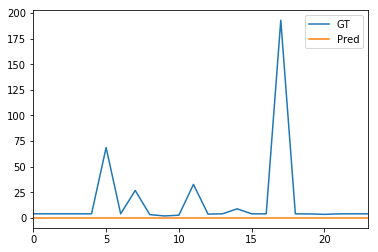

In [284]:
pd.Series(test_mw[1, :]).plot(label='GT')
#pd.Series(test_agg[1, :]).plot(label='GT')


pd.Series(model.predict(test_agg[1:2])[0, :24]).plot(label='Pred')




plt.legend()